System of ODE:

$$\frac{dV}{dt} = \gamma [I_{Na} - (E_0 + \delta \cdot \frac{E_{max} \cdot P^n}{P^n + P_{50}^n} \cdot (1-A))]$$

$$\frac{dA}{dt} = \frac{1}{\tau_A} [\frac{A_{max}}{1 + (P/P_0)^m} - A]$$

$$\frac{dR}{dt} = \frac{1}{\tau_R} [R_0 + \alpha \cdot \frac{1}{\delta} \cdot A + \rho \cdot \frac{1}{1+(P/P_{set})^k} - R]$$

$$\frac{dP}{dt} = \frac{1}{\tau_P} (k_p \cdot V \cdot R - P)$$

In [42]:
#importing libraries
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from matplotlib import cm

In [4]:
class BPDynamicsModel:
    def __init__(self, delta=1.0, I_Na=150):
        # Model parameters based on the table provided
        self.gamma = 0.007      # Volume per mmol Na+ (L/mmol)
        self.E_0 = 40           # Baseline Na+ excretion (mmol/day)
        self.E_max = 120        # Maximum excretion capacity (mmol/day)
        self.P_50 = 95          # Pressure for half-max excretion (mmHg)
        self.n = 3              # Excretion Hill coefficient
        self.delta = delta      # Salt sensitivity factor
        self.R_0 = 1.2          # Baseline resistance (mmHg·min/L)
        self.alpha = 0.3        # RAAS effect on resistance (mmHg·min/L)
        self.rho = 0.3          # Baroreflex contribution (mmHg·min/L)
        self.tau_A = 30         # RAAS time constant (min)
        self.tau_R = 3          # Resistance time constant (min)
        self.tau_P = 5          # Pressure time constant (min)
        self.A_max = 1.0        # Maximum RAAS activity
        self.P_0 = 90           # Reference pressure for RAAS (mmHg)
        self.P_set = 95         # Pressure setpoint for baroreflex (mmHg)
        self.m = 2              # RAAS Hill coefficient
        self.k = 4              # Baroreflex Hill coefficient
        self.k_p = 15           # Pressure-volume-resistance constant

        # Convert I_Na from mmol/day to mmol/min for simulation
        self.I_Na = I_Na / 1440  # 1440 minutes in a day

        # For unit conversion in outputs
        self._day_to_min = 1440

    def compute_derivatives(self, t, y):
        V, A, R, P = y

        # Convert units for excretion (from mmol/day to mmol/min)
        E_0_min = self.E_0 / self._day_to_min
        E_max_min = self.E_max / self._day_to_min

        # Sodium excretion term
        excretion = E_0_min + self.delta * (E_max_min * P**self.n) / (P**self.n + self.P_50**self.n) * (1 - A)

        # Compute derivatives
        dVdt = self.gamma * (self.I_Na - excretion)
        dAdt = (1/self.tau_A) * (self.A_max / (1 + (P/self.P_0)**self.m) - A)
        dRdt = (1/self.tau_R) * (self.R_0 + self.alpha * (1/self.delta) * A +
                                self.rho * (1 / (1 + (P/self.P_set)**self.k)) - R)
        dPdt = (1/self.tau_P) * (self.k_p * V * R - P)

        return [dVdt, dAdt, dRdt, dPdt]

    def simulate(self, initial_conditions, t_span, t_eval=None):
        sol = solve_ivp(
            fun=self.compute_derivatives,
            t_span=t_span,
            y0=initial_conditions,
            method='RK45',
            t_eval=t_eval,
            rtol=1e-6,
            atol=1e-8
        )
        return sol

    def compute_steady_state(self, P_range):
        V_ss = np.zeros_like(P_range)
        A_ss = np.zeros_like(P_range)
        R_ss = np.zeros_like(P_range)

        for i, P in enumerate(P_range):
            # Steady state for A
            A = self.A_max / (1 + (P/self.P_0)**self.m)
            A_ss[i] = A

            # Steady state for R
            R = self.R_0 + self.alpha * (1/self.delta) * A + self.rho * (1 / (1 + (P/self.P_set)**self.k))
            R_ss[i] = R

            # Steady state for V
            V = P / (self.k_p * R)
            V_ss[i] = V

        return {
            'P': P_range,
            'V': V_ss,
            'A': A_ss,
            'R': R_ss
        }

    def create_parameter_table(self):
        params = {
            'Parameter': ['γ', 'E₀', 'E_max', 'P₅₀', 'n', 'δ', 'R₀',
                         'α', 'ρ', 'τₐ', 'τᵣ', 'τₚ', 'A_max',
                         'P₀', 'P_set', 'm', 'k', 'k_p', 'I_Na'],
            'Description': ['Volume per mmol Na⁺', 'Baseline Na⁺ excretion',
                           'Maximum excretion capacity', 'Pressure for half-max excretion',
                           'Excretion Hill coefficient', 'Salt sensitivity factor',
                           'Baseline resistance', 'RAAS effect on resistance',
                           'Baroreflex contribution', 'RAAS time constant',
                           'Resistance time constant', 'Pressure time constant',
                           'Maximum RAAS activity', 'Reference pressure for RAAS',
                           'Pressure setpoint for baroreflex', 'RAAS Hill coefficient',
                           'Baroreflex Hill coefficient', 'Pressure-volume-resistance constant',
                           'Sodium intake'],
            'Value': [self.gamma, self.E_0, self.E_max, self.P_50, self.n, self.delta,
                     self.R_0, self.alpha, self.rho, self.tau_A, self.tau_R, self.tau_P,
                     self.A_max, self.P_0, self.P_set, self.m, self.k, self.k_p,
                     self.I_Na * 1440],  # Convert back to mmol/day for display
            'Units': ['L/mmol', 'mmol/day', 'mmol/day', 'mmHg', '-', '-',
                     'mmHg·min/L', 'mmHg·min/L', 'mmHg·min/L', 'min',
                     'min', 'min', '-', 'mmHg', 'mmHg', '-', '-', '-', 'mmol/day']
        }

        return pd.DataFrame(params)

In [5]:
def plot_time_evolution_with_table(delta_values=[1.0, 0.5, 0.3], I_Na=150, V0=5, P0=90, t_r=0.25):
    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # t_r = 0.25 # time range

    # Time settings for simulation (in minutes)
    t_span = (0, t_r * 24 * 60)  # 24 hours in minutes
    t_eval = np.linspace(0, t_r * 24 * 60, 100000)  # 1000 evaluation points

    # Colors for different delta values
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Dictionary to store data for table
    table_data = {}

    # Run simulations for each delta value
    for i, delta in enumerate(delta_values):
        model = BPDynamicsModel(delta=delta, I_Na=I_Na)

        # Calculate approximate steady state values for A and R based on P0
        A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
        R0 = model.R_0 + model.alpha * (1/delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))

        initial_conditions = [V0, A0, R0, P0]
        sol = model.simulate(initial_conditions, t_span, t_eval)

        # Extract solution
        t_hours = sol.t / 60  # Convert minutes to hours
        V, A, R, P = sol.y

        # Plot time evolution
        label = f'δ = {delta}'
        ax1.plot(t_hours, P, label=label, color=colors[i], linewidth=2)
        ax2.plot(t_hours, V, label=label, color=colors[i], linewidth=2)

        # Extract data for table (initial, 6h, 12h, 24h)
        indices = [0, int(len(t_hours)/4), int(len(t_hours)/2), -1]
        table_data[f'δ={delta}'] = {
            'Time (h)': [t_hours[idx] for idx in indices],
            'P (mmHg)': [P[idx] for idx in indices],
            'V (L)': [V[idx] for idx in indices],
            'RAAS Activity': [A[idx] for idx in indices],
            'Resistance (mmHg·min/L)': [R[idx] for idx in indices]
        }

    # Set titles and labels
    ax1.set_title(f'Time Evolution of Blood Pressure (Na+ Intake: {I_Na} mmol/day)', fontsize=14)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Blood Pressure (mmHg)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_title('Time Evolution of Blood Volume', fontsize=14)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Blood Volume (L)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add a super title with simulation information
    plt.suptitle(f"Blood Pressure Dynamics Model\nInitial Conditions: V₀={V0}L, P₀={P0}mmHg, Na⁺ Intake={I_Na}mmol/day",
                fontsize=16, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Create and display tables for each delta value
    print("Numerical Values at Selected Time Points:")
    for delta, data in table_data.items():
        print(f"\nSimulation with {delta}")
        df = pd.DataFrame({
            'Time (h)': data['Time (h)'],
            'Pressure (mmHg)': [round(p, 1) for p in data['P (mmHg)']],
            'Volume (L)': [round(v, 3) for v in data['V (L)']],
            'RAAS Activity': [round(a, 3) for a in data['RAAS Activity']],
            'Resistance (mmHg·min/L)': [round(r, 3) for r in data['Resistance (mmHg·min/L)']]
        })
        display(df)

<ipython-input-5-cc0ce0fa3476>:68: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
<ipython-input-5-cc0ce0fa3476>:68: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


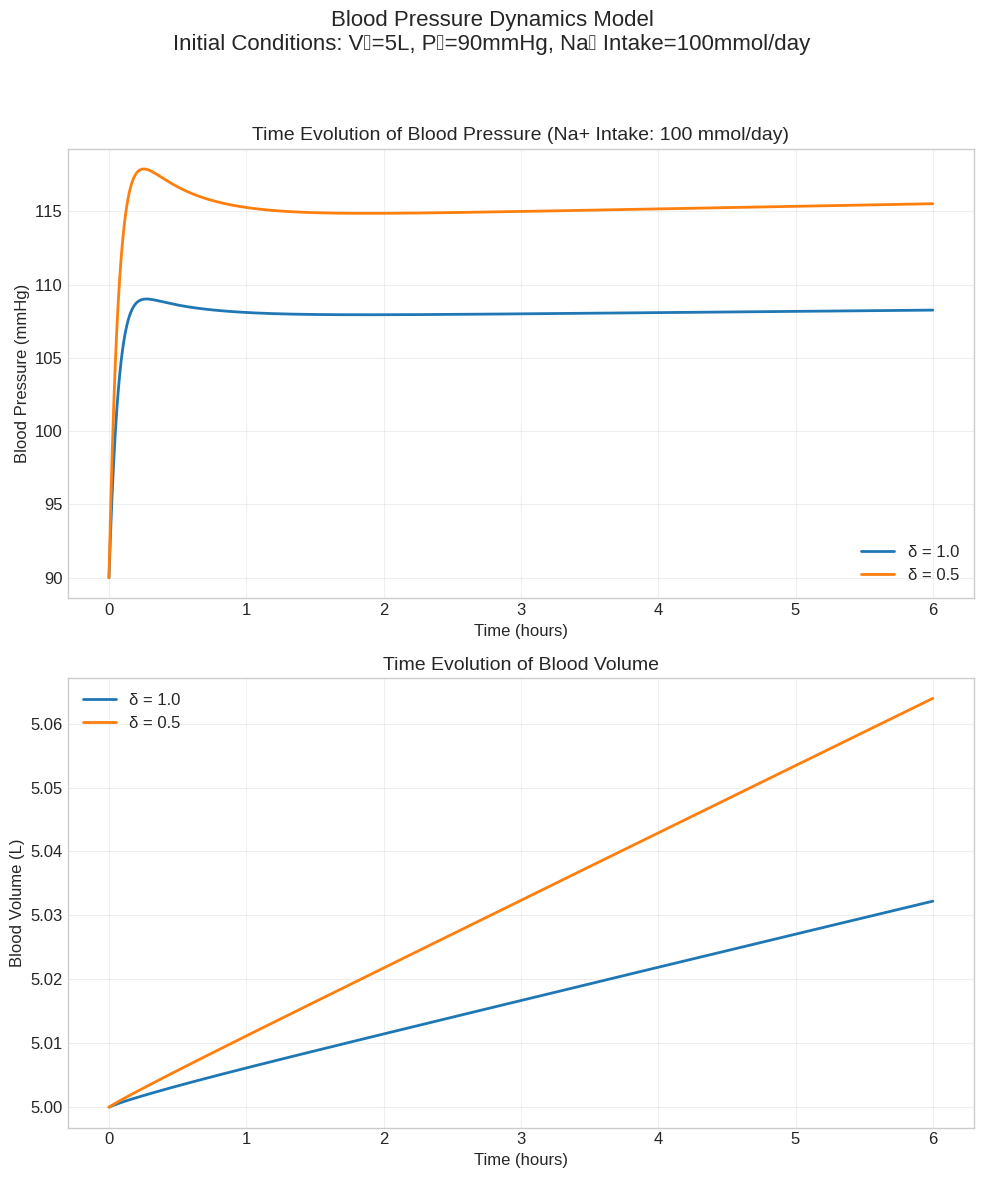

Numerical Values at Selected Time Points:

Simulation with δ=1.0


Time (h)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0  0.000000             90.0       5.000          0.500   
1  1.500015            108.0       5.009          0.414   
2  3.000030            108.0       5.017          0.410   
3  6.000000            108.3       5.032          0.409   

   Resistance (mmHg·min/L)  
0                    1.516  
1                    1.437  
2                    1.435  
3                    1.434


Simulation with δ=0.5


Time (h)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0  0.000000             90.0       5.000          0.500   
1  1.500015            114.9       5.016          0.385   
2  3.000030            115.0       5.032          0.380   
3  6.000000            115.5       5.064          0.378   

   Resistance (mmHg·min/L)  
0                    1.666  
1                    1.527  
2                    1.524  
3                    1.521

In [6]:
plot_time_evolution_with_table(delta_values=[1.0, 0.5], I_Na=100, V0=5, P0=90, t_r=0.25)

For $I_Na$ = 150:
### There is a sudden inital spike (90 mmHg to ~110-117 mmHg)
1. **Immediate Volume-Pressure Effect**: The simulation begins with a salt intake of 150 mmol/day, which exceeds the initial steady-state sodium excretion rate that would have maintained the 90 mmHg pressure. This causes immediate volume retention.

2. **Fast Time Constant**: The pressure equation has a relatively fast time constant (τ_P = 5 min), causing pressure to quickly respond to the product of volume and resistance (P = k_p·V·R).

3. **Delayed Compensation**: While volume starts increasing immediately, the compensatory mechanisms (baroreflex and RAAS) have not yet fully activated.

### Then there is a small decline/plateau for some time

1. **Baroreflex Activation**: The increased pressure triggers the baroreflex mechanism, reducing vascular resistance with time constant τ_R = 3 min.

2. **RAAS Suppression**: The elevated pressure gradually suppresses RAAS activity (A decreases from 0.5 to ~0.4), which further reduces resistance.

3. **These feedback mechanisms temporarily "overcompensate"** for the initial pressure spike, causing the slight decline.

### Then there is a gradual Rise
1. **Continuous Volume Accumulation**: As shown in the volume graph, blood volume keeps increasing steadily as sodium intake exceeds excretion.

2. **Pressure Natriuresis Requirement**: Higher pressure is necessary to increase sodium excretion enough to match the **Increased intake**.

3. **Salt Sensitivity Effect**: In the salt-sensitive case (δ=0.5), the pressure must rise more to achieve the same excretion rate, explaining the steeper increase.

### Due to different time scales
1. Fast: Direct pressure-volume-resistance relationship
2. Medium: Baroreflex and RAAS activity changes
3. Slow: Cumulative volume retention

<ipython-input-5-cc0ce0fa3476>:68: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
<ipython-input-5-cc0ce0fa3476>:68: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


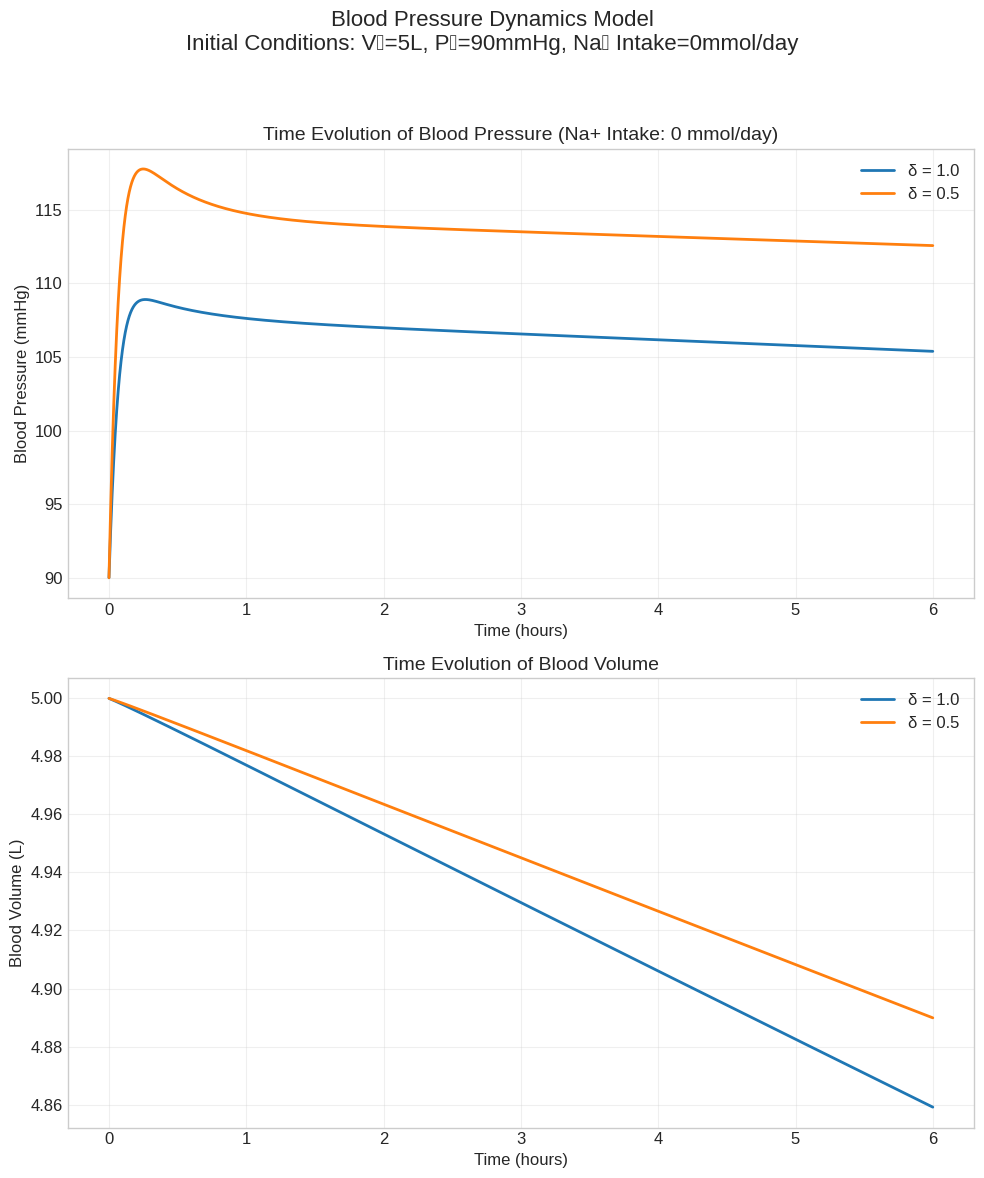

Numerical Values at Selected Time Points:

Simulation with δ=1.0


Time (h)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0  0.000000             90.0       5.000          0.500   
1  1.500015            107.2       4.965          0.416   
2  3.000030            106.6       4.930          0.416   
3  6.000000            105.4       4.859          0.421   

   Resistance (mmHg·min/L)  
0                    1.516  
1                    1.439  
2                    1.441  
3                    1.445


Simulation with δ=0.5


Time (h)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0  0.000000             90.0       5.000          0.500   
1  1.500015            114.2       4.973          0.387   
2  3.000030            113.5       4.945          0.385   
3  6.000000            112.6       4.890          0.389   

   Resistance (mmHg·min/L)  
0                    1.666  
1                    1.530  
2                    1.530  
3                    1.534

In [30]:
plot_time_evolution_with_table(delta_values=[1.0, 0.5], I_Na=0, V0=5, P0=90, t_r=0.25)

# For $I_Na$ = 0

### Here we stoped the salt intake in body (different from regular)
Our simulation is using these initial conditions:
- Blood volume: 5L
- Blood pressure: 90 mmHg
- Sodium intake: **0 mmol/day**

The key issue is the mismatch between the initial state and the sodium intake:

### Initial Pressure Spike Mechanism

1. **Volume-Pressure Relationship**:
   - You've initialized volume at 5L, which is higher than would be sustainable with zero sodium intake
   - When the simulation begins, this excess volume immediately drives up pressure according to your equation: $dP/dt = (1/τ_P) * (k_p * V * R - P)$
   - With V=5L, the target pressure $(k_p * V * R)$ is much higher than 90 mmHg

2. **Time Constant Effects**:
   - Pressure responds fastest (small τ_P)
   - RAAS and resistance respond more slowly (larger τ_A and τ_R)
   - Volume changes very slowly based on sodium balance (small γ)

3. **Salt Sensitivity Impact**:
   - The salt-sensitive model (δ=0.5) shows a larger spike (~114 mmHg vs ~107 mmHg)
   - This occurs because salt-sensitive individuals have reduced sodium excretion capacity for a given pressure

### Ongoing Volume Decrease

Your volume graph shows continuous decline because:

- With zero sodium intake but continuing excretion, the body is in negative sodium balance
- Sodium excretion continues due to pressure-natriuresis (E_Na equation)
- As sodium leaves, water follows (reflected in decreasing volume)

## Why This Differs From Previous Simulations

In your previous simulations showing steady state at 50 mmol/day sodium intake:
1. The system was truly at equilibrium (sodium in = sodium out)
2. All variables (P, V, A, R) were matched to that intake level

In this simulation:
1. There's a fundamental mismatch between 5L volume and 0 mmol/day intake
2. The system must spike pressure to begin eliminating excess volume


In [32]:
def plot_steady_state_volume_pressure_with_table(delta_values=[1.0, 0.5, 0.3]):
    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure
    plt.figure(figsize=(10, 8))

    # Pressure range for steady state analysis
    P_range = np.linspace(70, 160, 200)

    # Selected pressure points for table
    selected_pressures = [80, 90, 100, 120, 140]
    selected_indices = [np.abs(P_range - p).argmin() for p in selected_pressures]

    # Colors for different delta values
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Dictionary to store data for tables
    table_data = {}

    # Calculate steady state for each delta value
    for i, delta in enumerate(delta_values):
        model = BPDynamicsModel(delta=delta)
        ss_results = model.compute_steady_state(P_range)

        # Plot the steady state relationship
        plt.plot(P_range, ss_results['V'], label=f'δ = {delta}', color=colors[i], linewidth=2)

        # Store data for selected pressure points
        table_data[f'δ={delta}'] = {
            'Pressure (mmHg)': [P_range[idx] for idx in selected_indices],
            'Volume (L)': [ss_results['V'][idx] for idx in selected_indices],
            'RAAS Activity': [ss_results['A'][idx] for idx in selected_indices],
            'Resistance (mmHg·min/L)': [ss_results['R'][idx] for idx in selected_indices]
        }

    # Add vertical lines for key pressure values
    plt.axvline(x=100, color='gray', linestyle='--', alpha=0.5, label='Normal BP (90 mmHg)')
    plt.axvline(x=140, color='red', linestyle='--', alpha=0.5, label='Hypertension (140 mmHg)')

    # Set title and labels
    plt.title('Steady State Relationship: Volume vs Pressure', fontsize=14)
    plt.xlabel('Blood Pressure (mmHg)')
    plt.ylabel('Blood Volume (L)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add annotation with key relationship
    plt.annotate('V = P / (k_p · R)', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Create and display tables for each delta value
    print("Steady State Values at Selected Pressures:")
    for delta, data in table_data.items():
        print(f"\nSteady State Values for {delta}")
        df = pd.DataFrame({
            'Pressure (mmHg)': [round(p, 1) for p in data['Pressure (mmHg)']],
            'Volume (L)': [round(v, 3) for v in data['Volume (L)']],
            'RAAS Activity': [round(a, 3) for a in data['RAAS Activity']],
            'Resistance (mmHg·min/L)': [round(r, 3) for r in data['Resistance (mmHg·min/L)']]
        })
        display(df)

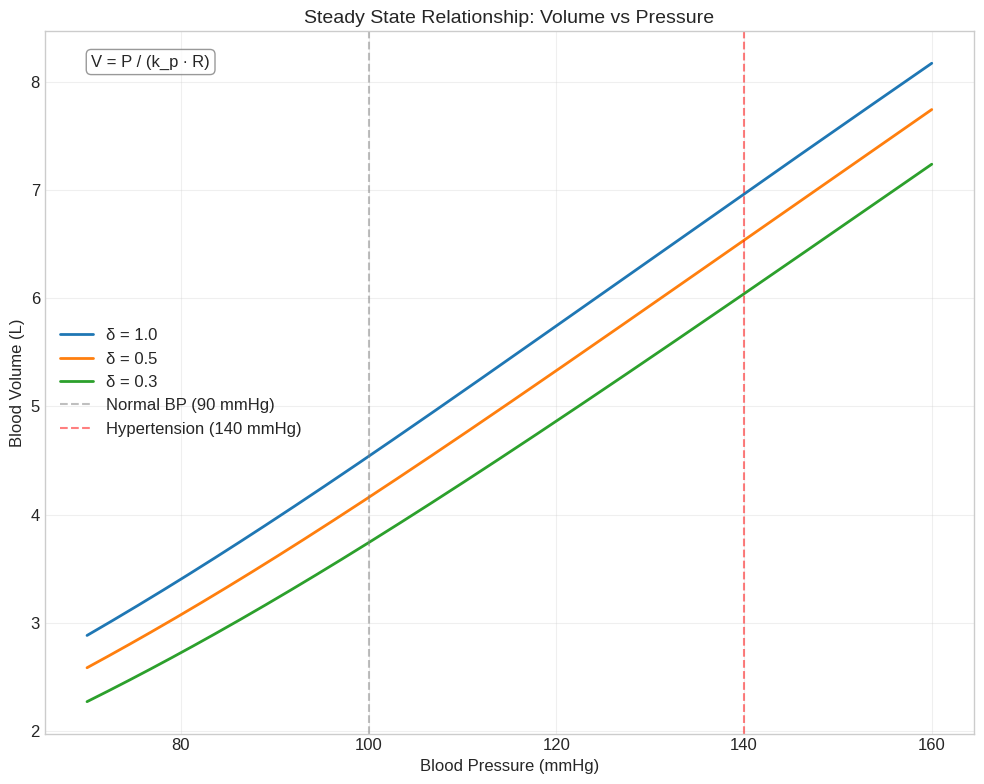

Steady State Values at Selected Pressures:

Steady State Values for δ=1.0


Pressure (mmHg)  Volume (L)  RAAS Activity  Resistance (mmHg·min/L)
0             79.9       3.400          0.559                    1.567
1             89.9       3.952          0.501                    1.517
2             99.8       4.530          0.448                    1.470
3            120.2       5.757          0.359                    1.392
4            140.1       6.970          0.292                    1.340


Steady State Values for δ=0.5


Pressure (mmHg)  Volume (L)  RAAS Activity  Resistance (mmHg·min/L)
0             79.9       3.072          0.559                    1.735
1             89.9       3.596          0.501                    1.667
2             99.8       4.150          0.448                    1.604
3            120.2       5.343          0.359                    1.500
4            140.1       6.542          0.292                    1.428


Steady State Values for δ=0.3


Pressure (mmHg)  Volume (L)  RAAS Activity  Resistance (mmHg·min/L)
0             79.9       2.721          0.559                    1.959
1             89.9       3.210          0.501                    1.867
2             99.8       3.733          0.448                    1.783
3            120.2       4.876          0.359                    1.643
4            140.1       6.047          0.292                    1.544

In [33]:
plot_steady_state_volume_pressure_with_table(delta_values=[1.0, 0.5, 0.3])

In [34]:
def plot_steady_state_raas_resistance_with_table(delta_values=[1.0, 0.5, 0.3]):
    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Pressure range for steady state analysis
    P_range = np.linspace(70, 160, 200)

    # Selected pressure points for table
    selected_pressures = [80, 90, 100, 120, 140]
    selected_indices = [np.abs(P_range - p).argmin() for p in selected_pressures]

    # Colors for different delta values
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Dictionary to store data for tables
    table_data = {}

    # Calculate steady state for each delta value
    for i, delta in enumerate(delta_values):
        model = BPDynamicsModel(delta=delta)
        ss_results = model.compute_steady_state(P_range)

        # Plot RAAS activity
        ax1.plot(P_range, ss_results['A'], label=f'δ = {delta}', color=colors[i], linewidth=2)

        # Plot Resistance
        ax2.plot(P_range, ss_results['R'], label=f'δ = {delta}', color=colors[i], linewidth=2)

        # Store data for selected pressure points
        table_data[f'δ={delta}'] = {
            'Pressure (mmHg)': [P_range[idx] for idx in selected_indices],
            'RAAS Activity': [ss_results['A'][idx] for idx in selected_indices],
            'Resistance (mmHg·min/L)': [ss_results['R'][idx] for idx in selected_indices]
        }

    # Set titles and labels for RAAS plot
    ax1.set_title('Steady State: RAAS Activity vs Pressure', fontsize=14)
    ax1.set_xlabel('Blood Pressure (mmHg)')
    ax1.set_ylabel('RAAS Activity (normalized)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Set titles and labels for Resistance plot
    ax2.set_title('Steady State: Vascular Resistance vs Pressure', fontsize=14)
    ax2.set_xlabel('Blood Pressure (mmHg)')
    ax2.set_ylabel('Resistance (mmHg·min/L)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add annotations with governing equations
    ax1.annotate('A = A_max / (1 + (P/P_0)^m)', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    ax2.annotate('R = R_0 + α·(1/δ)·A + ρ·(1/(1+(P/P_set)^k))', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.suptitle('Effect of Salt Sensitivity on RAAS Activity and Vascular Resistance', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Create and display tables for each delta value
    print("RAAS Activity and Resistance at Selected Pressures:")
    for delta, data in table_data.items():
        print(f"\nValues for {delta}")
        df = pd.DataFrame({
            'Pressure (mmHg)': [round(p, 1) for p in data['Pressure (mmHg)']],
            'RAAS Activity': [round(a, 3) for a in data['RAAS Activity']],
            'Resistance (mmHg·min/L)': [round(r, 3) for r in data['Resistance (mmHg·min/L)']]
        })
        display(df)

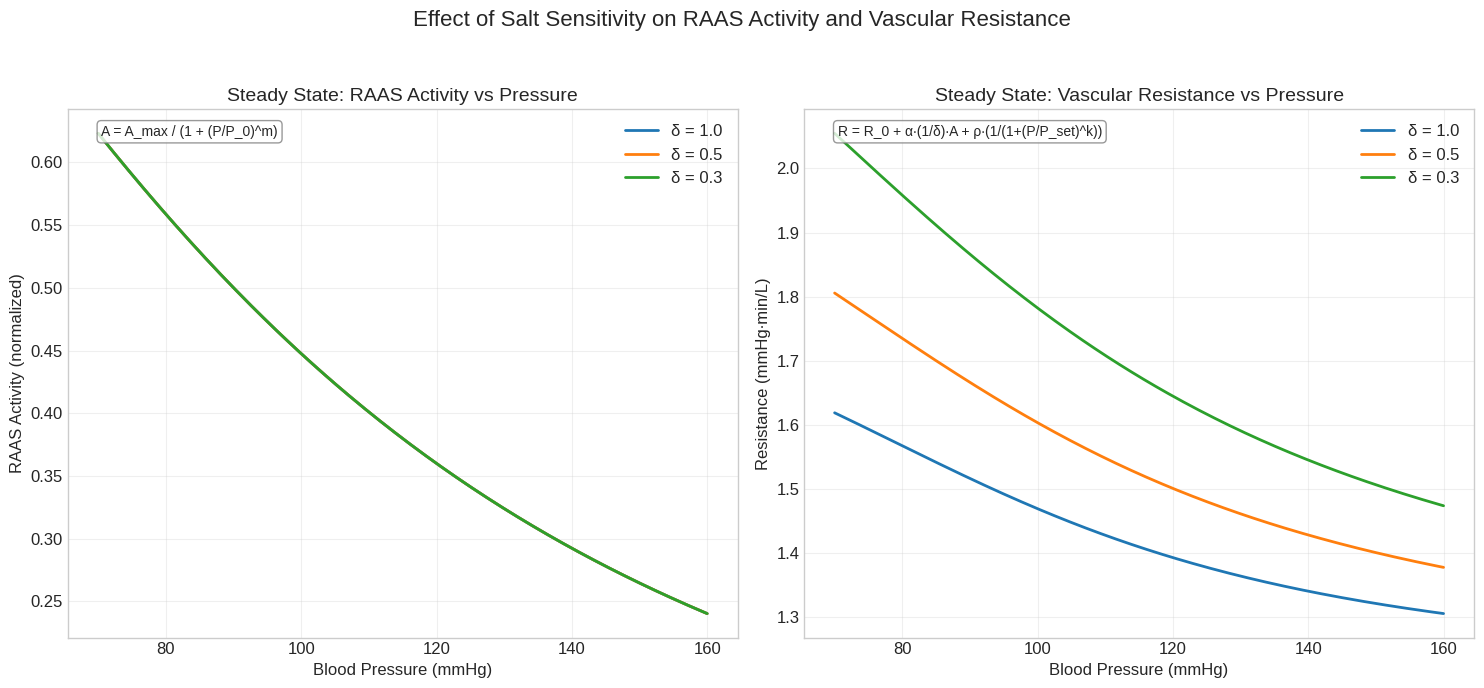

RAAS Activity and Resistance at Selected Pressures:

Values for δ=1.0


Pressure (mmHg)  RAAS Activity  Resistance (mmHg·min/L)
0             79.9          0.559                    1.567
1             89.9          0.501                    1.517
2             99.8          0.448                    1.470
3            120.2          0.359                    1.392
4            140.1          0.292                    1.340


Values for δ=0.5


Pressure (mmHg)  RAAS Activity  Resistance (mmHg·min/L)
0             79.9          0.559                    1.735
1             89.9          0.501                    1.667
2             99.8          0.448                    1.604
3            120.2          0.359                    1.500
4            140.1          0.292                    1.428


Values for δ=0.3


Pressure (mmHg)  RAAS Activity  Resistance (mmHg·min/L)
0             79.9          0.559                    1.959
1             89.9          0.501                    1.867
2             99.8          0.448                    1.783
3            120.2          0.359                    1.643
4            140.1          0.292                    1.544

In [35]:
plot_steady_state_raas_resistance_with_table(delta_values=[1.0, 0.5, 0.3])

In [38]:
def animate_pressure_volume_trajectory_with_table(delta_values=[1.0, 0.5], I_Na=150, V0=5, P0=90):
    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Time settings for simulation (in minutes)
    t_span = (0, 24 * 60)  # 24 hours in minutes
    t_eval = np.linspace(0, 24 * 60, 500)  # 500 evaluation points

    # Colors for different delta values
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Run simulations for each delta value
    solutions = []

    # Dictionary to store data for tables
    table_data = {}

    for i, delta in enumerate(delta_values):
        model = BPDynamicsModel(delta=delta, I_Na=I_Na)

        # Calculate approximate steady state values for A and R based on P0
        A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
        R0 = model.R_0 + model.alpha * (1/delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))

        initial_conditions = [V0, A0, R0, P0]
        sol = model.simulate(initial_conditions, t_span, t_eval)
        solutions.append(sol)

        # Extract key points for table (initial, 6h, 12h, 24h)
        t_hours = sol.t / 60
        V, A, R, P = sol.y
        indices = [0, int(len(t_hours)/4), int(len(t_hours)/2), -1]

        table_data[f'δ={delta}'] = {
            'Time (h)': [t_hours[idx] for idx in indices],
            'Pressure (mmHg)': [P[idx] for idx in indices],
            'Volume (L)': [V[idx] for idx in indices]
        }

    # Prepare animation elements
    lines = []
    points = []

    for i, delta in enumerate(delta_values):
        V, A, R, P = solutions[i].y
        line, = ax.plot([], [], color=colors[i], label=f'δ = {delta}')
        point, = ax.plot([], [], 'o', color=colors[i], markersize=8)
        lines.append(line)
        points.append(point)

        # Set initial axis limits based on data
        if i == 0:
            P_min, P_max = np.min(P) - 5, np.max(P) + 5
            V_min, V_max = np.min(V) - 0.1, np.max(V) + 0.1
            ax.set_xlim(P_min, P_max)
            ax.set_ylim(V_min, V_max)
        else:
            P_min = min(P_min, np.min(P) - 5)
            P_max = max(P_max, np.max(P) + 5)
            V_min = min(V_min, np.min(V) - 0.1)
            V_max = max(V_max, np.max(V) + 0.1)
            ax.set_xlim(P_min, P_max)
            ax.set_ylim(V_min, V_max)

    # Set title and labels
    ax.set_title(f'Pressure-Volume Trajectory (Na+ Intake: {I_Na} mmol/day)', fontsize=14)
    ax.set_xlabel('Blood Pressure (mmHg)')
    ax.set_ylabel('Blood Volume (L)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add annotation for initial point
    ax.annotate(f"Initial: (P₀={P0}, V₀={V0})",
                xy=(P0, V0), xytext=(P0+10, V0+0.1),
                arrowprops=dict(arrowstyle="->", color="black"))

    def init():
        for line, point in zip(lines, points):
            line.set_data([], [])
            point.set_data([], [])
        return lines + points

    def animate(i):
        # Only show fraction of data up to frame i
        idx = int(i * len(t_eval) / 100)
        if idx == 0:
            idx = 1

        for j, (line, point) in enumerate(zip(lines, points)):
            V, A, R, P = solutions[j].y
            line.set_data(P[:idx], V[:idx])
            point.set_data(P[idx-1:idx], V[idx-1:idx])

        return lines + points

    ani = FuncAnimation(fig, animate, frames=100, init_func=init, blit=True, interval=100)

    # Display the animation in the notebook
    plt.close()  # Prevent double display

    # Create and display tables for each delta value
    print("Pressure-Volume Trajectory Data at Selected Time Points:")
    for delta, data in table_data.items():
        print(f"\nTrajectory Data for {delta}")
        df = pd.DataFrame({
            'Time (h)': [round(t, 1) for t in data['Time (h)']],
            'Pressure (mmHg)': [round(p, 1) for p in data['Pressure (mmHg)']],
            'Volume (L)': [round(v, 3) for v in data['Volume (L)']]
        })
        display(df)

    return HTML(ani.to_jshtml())

In [41]:
animate_pressure_volume_trajectory_with_table(delta_values=[1.0, 0.5], I_Na=250, V0=5, P0=90)

Pressure-Volume Trajectory Data at Selected Time Points:

Trajectory Data for δ=1.0


<ipython-input-38-a93cfd65a8a8>:100: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  ani = FuncAnimation(fig, animate, frames=100, init_func=init, blit=True, interval=100)


Time (h)  Pressure (mmHg)  Volume (L)
0       0.0             90.0       5.000
1       6.0            112.6       5.293
2      12.0            117.2       5.578
3      24.0            126.3       6.128


Trajectory Data for δ=0.5


Time (h)  Pressure (mmHg)  Volume (L)
0       0.0             90.0       5.000
1       6.0            119.9       5.326
2      12.0            125.3       5.647
3      24.0            135.8       6.279

<ipython-input-38-a93cfd65a8a8>:116: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  return HTML(ani.to_jshtml())


# Pressure-Volume Trajectories Across Different Salt Intakes

## For Moderate Salt Intake (80 - 90 mmol/day)

### Normal Individual (δ=1.0):
- **Pressure**: Quick rise to equilibrium (~107.7 mmHg) and then stabilizes
- **Volume**: Slight decrease over time (5.000L → 4.988L)
- **Mechanism**: Efficient pressure natriuresis allows sodium excretion to match intake once pressure reaches ~107 mmHg, maintaining stable volume

### Salt-Sensitive Individual (δ=0.5):
- **Pressure**: Higher rise (to 114.9 mmHg) and continues increasing
- **Volume**: Progressive increase (5.000L → 5.113L)  
- **Mechanism**: Impaired pressure natriuresis requires both higher pressure and volume retention to maintain sodium balance

## How This Would Change at Different Salt Intakes

### For Low Salt Intake (50-70 mmol/day):

1. **Normal Individual (δ=1.0):**
   - Pressure would rise less (perhaps to ~95-100 mmHg)
   - Volume would decrease more substantially
   - Eventually would reach a lower steady-state pressure

2. **Salt-Sensitive Individual (δ=0.5):**
   - Pressure would still rise but less dramatically
   - Volume might show minimal change or slight decrease
   - Would maintain a higher pressure than normal individuals despite low salt intake

### For High Salt Intake (250+ mmol/day):

1. **Normal Individual (δ=1.0):**
   - Pressure would rise more (perhaps to ~120-125 mmHg)
   - Volume would increase moderately
   - Would eventually stabilize at a higher setpoint

2. **Salt-Sensitive Individual (δ=0.5):**
   - Dramatic pressure increase (potentially >130-140 mmHg)
   - Substantial volume retention
   - Progressive worsening over time, potentially not reaching equilibrium within 24 hours

## The Mathematical Explanation

The key equation governing this behavior is:

$$\frac{dV}{dt} = \gamma \left[ I_{\text{Na}} - \left( E_0 + \delta \cdot \frac{E_{\text{max}} \cdot P^n}{P^n + P_{50}^n} \cdot (1 - A) \right) \right]$$

When δ is reduced:
1. Less sodium is excreted at any given pressure
2. To maintain sodium balance, either P must increase or (1-A) must increase
3. A higher pressure stimulates more natriuresis but also suppresses RAAS (decreasing A)
4. The combined effect is a higher steady-state pressure and greater volume retention

This elegantly explains why salt-sensitive individuals show both higher blood pressure and greater volume retention, especially with increasing salt loads - their reduced renal excretion capacity requires these changes to maintain sodium balance.

In [43]:
def plot_salt_intake_response_with_table(delta_values=[1.0, 0.5],
                             salt_intakes=[70, 150, 250]):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure
    plt.figure(figsize=(10, 8))

    # Generate colors dynamically based on the number of delta values
    # This uses a colormap to generate enough distinct colors for any number of delta values
    colormap = cm.get_cmap('viridis', len(delta_values))
    colors = [colormap(i) for i in range(len(delta_values))]

    # Simulate 24 hours for each combination
    t_span = (0, 24 * 60)  # minutes

    # Initialize baseline volume and pressure
    V0 = 5.0  # liters
    P0 = 90   # mmHg

    # Store steady-state values
    ss_pressures = np.zeros((len(delta_values), len(salt_intakes)))
    ss_volumes = np.zeros((len(delta_values), len(salt_intakes)))
    ss_raas = np.zeros((len(delta_values), len(salt_intakes)))
    ss_resistance = np.zeros((len(delta_values), len(salt_intakes)))

    # Run simulations
    for i, delta in enumerate(delta_values):
        for j, salt_intake in enumerate(salt_intakes):
            # Create model with specified salt intake
            model = BPDynamicsModel(delta=delta, I_Na=salt_intake)

            # Calculate approximate steady state values for A and R based on P0
            A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
            R0 = model.R_0 + model.alpha * (1/delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))

            initial_conditions = [V0, A0, R0, P0]
            sol = model.simulate(initial_conditions, t_span)

            # Extract final values (steady state)
            ss_volumes[i, j] = sol.y[0][-1]
            ss_raas[i, j] = sol.y[1][-1]
            ss_resistance[i, j] = sol.y[2][-1]
            ss_pressures[i, j] = sol.y[3][-1]

    # Plot results
    for i, delta in enumerate(delta_values):
        plt.plot(salt_intakes, ss_pressures[i], 'o-', label=f'δ = {delta}', color=colors[i], linewidth=2)

    # Rest of function remains the same...
    # Add reference lines
    plt.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='Normal BP (90 mmHg)')
    plt.axhline(y=140, color='red', linestyle='--', alpha=0.5, label='Hypertension (140 mmHg)')

    # Set title and labels
    plt.title('Steady-State Blood Pressure Response to Salt Intake', fontsize=14)
    plt.xlabel('Sodium Intake (mmol/day)')
    plt.ylabel('Steady-State Blood Pressure (mmHg)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Annotate normal vs high salt intake zones
    plt.axvspan(0, 100, alpha=0.1, color='green', label='Low Salt')
    plt.axvspan(100, 180, alpha=0.1, color='blue', label='Normal Salt')
    plt.axvspan(180, max(salt_intakes)+20, alpha=0.1, color='red', label='High Salt')

    plt.tight_layout()
    plt.show()

    # Create and display tables as before
    print("Steady State Values for Different Salt Intakes and Salt Sensitivities:")

    # Create table for each delta value
    for i, delta in enumerate(delta_values):
        print(f"\nValues for δ = {delta}:")

        data = {
            'Na+ Intake (mmol/day)': salt_intakes,
            'Pressure (mmHg)': [round(p, 1) for p in ss_pressures[i]],
            'Volume (L)': [round(v, 3) for v in ss_volumes[i]],
            'RAAS Activity': [round(a, 3) for a in ss_raas[i]],
            'Resistance (mmHg·min/L)': [round(r, 3) for r in ss_resistance[i]]
        }

        df = pd.DataFrame(data)
        display(df)

    # Create delta comparison table for each salt intake
    print("\nComparing Salt Sensitivities at Different Intake Levels:")

    for j, intake in enumerate(salt_intakes):
        print(f"\nAt Na+ Intake = {intake} mmol/day:")

        data = {
            'Salt Sensitivity (δ)': delta_values,
            'Pressure (mmHg)': [round(ss_pressures[i, j], 1) for i in range(len(delta_values))],
            'Volume (L)': [round(ss_volumes[i, j], 3) for i in range(len(delta_values))],
            'RAAS Activity': [round(ss_raas[i, j], 3) for i in range(len(delta_values))],
            'Resistance (mmHg·min/L)': [round(ss_resistance[i, j], 3) for i in range(len(delta_values))]
        }

        df = pd.DataFrame(data)
        display(df)

<ipython-input-43-d6403e132603>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis', len(delta_values))


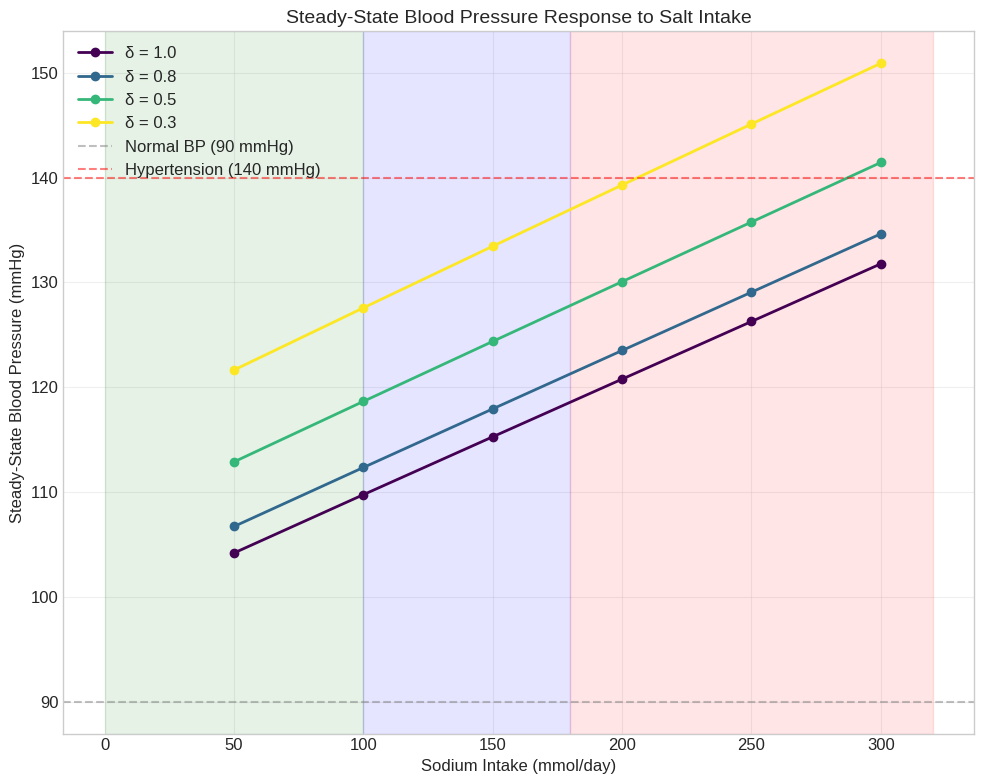

Steady State Values for Different Salt Intakes and Salt Sensitivities:

Values for δ = 1.0:


Na+ Intake (mmol/day)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                     50            104.2       4.787          0.427   
1                    100            109.7       5.122          0.402   
2                    150            115.3       5.457          0.379   
3                    200            120.8       5.792          0.358   
4                    250            126.3       6.128          0.338   
5                    300            131.8       6.464          0.320   

   Resistance (mmHg·min/L)  
0                    1.451  
1                    1.429  
2                    1.409  
3                    1.391  
4                    1.374  
5                    1.360


Values for δ = 0.8:


Na+ Intake (mmol/day)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                     50            106.7       4.834          0.415   
1                    100            112.3       5.172          0.391   
2                    150            117.9       5.510          0.369   
3                    200            123.5       5.848          0.348   
4                    250            129.1       6.187          0.329   
5                    300            134.6       6.526          0.310   

   Resistance (mmHg·min/L)  
0                    1.471  
1                    1.448  
2                    1.427  
3                    1.408  
4                    1.391  
5                    1.376


Values for δ = 0.5:


Na+ Intake (mmol/day)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                     50            112.9       4.908          0.389   
1                    100            118.6       5.250          0.366   
2                    150            124.4       5.593          0.344   
3                    200            130.1       5.936          0.325   
4                    250            135.8       6.279          0.307   
5                    300            141.4       6.622          0.290   

   Resistance (mmHg·min/L)  
0                    1.533  
1                    1.507  
2                    1.483  
3                    1.461  
4                    1.442  
5                    1.425


Values for δ = 0.3:


Na+ Intake (mmol/day)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                     50            121.6       4.960          0.354   
1                    100            127.6       5.305          0.333   
2                    150            133.4       5.651          0.313   
3                    200            139.3       5.997          0.296   
4                    250            145.1       6.343          0.279   
5                    300            150.9       6.689          0.264   

   Resistance (mmHg·min/L)  
0                    1.635  
1                    1.603  
2                    1.575  
3                    1.549  
4                    1.526  
5                    1.505


Comparing Salt Sensitivities at Different Intake Levels:

At Na+ Intake = 50 mmol/day:


Salt Sensitivity (δ)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                   1.0            104.2       4.787          0.427   
1                   0.8            106.7       4.834          0.415   
2                   0.5            112.9       4.908          0.389   
3                   0.3            121.6       4.960          0.354   

   Resistance (mmHg·min/L)  
0                    1.451  
1                    1.471  
2                    1.533  
3                    1.635


At Na+ Intake = 100 mmol/day:


Salt Sensitivity (δ)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                   1.0            109.7       5.122          0.402   
1                   0.8            112.3       5.172          0.391   
2                   0.5            118.6       5.250          0.366   
3                   0.3            127.6       5.305          0.333   

   Resistance (mmHg·min/L)  
0                    1.429  
1                    1.448  
2                    1.507  
3                    1.603


At Na+ Intake = 150 mmol/day:


Salt Sensitivity (δ)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                   1.0            115.3       5.457          0.379   
1                   0.8            117.9       5.510          0.369   
2                   0.5            124.4       5.593          0.344   
3                   0.3            133.4       5.651          0.313   

   Resistance (mmHg·min/L)  
0                    1.409  
1                    1.427  
2                    1.483  
3                    1.575


At Na+ Intake = 200 mmol/day:


Salt Sensitivity (δ)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                   1.0            120.8       5.792          0.358   
1                   0.8            123.5       5.848          0.348   
2                   0.5            130.1       5.936          0.325   
3                   0.3            139.3       5.997          0.296   

   Resistance (mmHg·min/L)  
0                    1.391  
1                    1.408  
2                    1.461  
3                    1.549


At Na+ Intake = 250 mmol/day:


Salt Sensitivity (δ)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                   1.0            126.3       6.128          0.338   
1                   0.8            129.1       6.187          0.329   
2                   0.5            135.8       6.279          0.307   
3                   0.3            145.1       6.343          0.279   

   Resistance (mmHg·min/L)  
0                    1.374  
1                    1.391  
2                    1.442  
3                    1.526


At Na+ Intake = 300 mmol/day:


Salt Sensitivity (δ)  Pressure (mmHg)  Volume (L)  RAAS Activity  \
0                   1.0            131.8       6.464          0.320   
1                   0.8            134.6       6.526          0.310   
2                   0.5            141.4       6.622          0.290   
3                   0.3            150.9       6.689          0.264   

   Resistance (mmHg·min/L)  
0                    1.360  
1                    1.376  
2                    1.425  
3                    1.505

In [44]:
plot_salt_intake_response_with_table(
    delta_values=[1.0, 0.8, 0.5, 0.3],
    salt_intakes=[50, 100, 150, 200, 250, 300]
)

In [45]:
def analyze_parameter_sensitivity_with_table():
    """
    Analyze sensitivity of blood pressure to various model parameters with tabular data
    """
    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Base parameters
    V0 = 5.0  # liters
    P0 = 90   # mmHg
    I_Na = 150  # mmol/day
    t_span = (0, 24 * 60)  # minutes

    # Parameter ranges to test
    delta_range = np.linspace(0.2, 1.0, 9)
    k_p_range = np.linspace(10, 20, 5)
    alpha_range = np.linspace(0.1, 0.5, 5)
    rho_range = np.linspace(0.1, 0.5, 5)

    # Dictionaries to store results for tables
    results = {
        'delta': {'Parameter': delta_range, 'Pressure': []},
        'k_p': {'Parameter': k_p_range, 'Pressure': []},
        'alpha': {'Parameter': alpha_range, 'Pressure': []},
        'rho': {'Parameter': rho_range, 'Pressure': []}
    }

    # Analyze delta sensitivity
    for delta in delta_range:
        model = BPDynamicsModel(delta=delta, I_Na=I_Na)
        A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
        R0 = model.R_0 + model.alpha * (1/delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))
        sol = model.simulate([V0, A0, R0, P0], t_span)
        results['delta']['Pressure'].append(sol.y[3][-1])

    axs[0, 0].plot(delta_range, results['delta']['Pressure'], 'o-', linewidth=2)
    axs[0, 0].set_title('Blood Pressure Sensitivity to δ', fontsize=14)
    axs[0, 0].set_xlabel('Salt Sensitivity Factor (δ)')
    axs[0, 0].set_ylabel('Steady-State BP (mmHg)')
    axs[0, 0].grid(True, alpha=0.3)

    # Analyze k_p sensitivity
    for k_p in k_p_range:
        model = BPDynamicsModel(I_Na=I_Na)
        model.k_p = k_p
        A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
        R0 = model.R_0 + model.alpha * (1/model.delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))
        sol = model.simulate([V0, A0, R0, P0], t_span)
        results['k_p']['Pressure'].append(sol.y[3][-1])

    axs[0, 1].plot(k_p_range, results['k_p']['Pressure'], 'o-', linewidth=2, color='orange')
    axs[0, 1].set_title('Blood Pressure Sensitivity to k_p', fontsize=14)
    axs[0, 1].set_xlabel('Pressure-Volume-Resistance Constant (k_p)')
    axs[0, 1].set_ylabel('Steady-State BP (mmHg)')
    axs[0, 1].grid(True, alpha=0.3)

    # Analyze alpha sensitivity
    for alpha in alpha_range:
        model = BPDynamicsModel(I_Na=I_Na)
        model.alpha = alpha
        A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
        R0 = model.R_0 + model.alpha * (1/model.delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))
        sol = model.simulate([V0, A0, R0, P0], t_span)
        results['alpha']['Pressure'].append(sol.y[3][-1])

    axs[1, 0].plot(alpha_range, results['alpha']['Pressure'], 'o-', linewidth=2, color='green')
    axs[1, 0].set_title('Blood Pressure Sensitivity to α', fontsize=14)
    axs[1, 0].set_xlabel('RAAS Effect on Resistance (α)')
    axs[1, 0].set_ylabel('Steady-State BP (mmHg)')
    axs[1, 0].grid(True, alpha=0.3)

    # Analyze rho sensitivity
    for rho in rho_range:
        model = BPDynamicsModel(I_Na=I_Na)
        model.rho = rho
        A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
        R0 = model.R_0 + model.alpha * (1/model.delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))
        sol = model.simulate([V0, A0, R0, P0], t_span)
        results['rho']['Pressure'].append(sol.y[3][-1])

    axs[1, 1].plot(rho_range, results['rho']['Pressure'], 'o-', linewidth=2, color='purple')
    axs[1, 1].set_title('Blood Pressure Sensitivity to ρ', fontsize=14)
    axs[1, 1].set_xlabel('Baroreflex Contribution (ρ)')
    axs[1, 1].set_ylabel('Steady-State BP (mmHg)')
    axs[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Parameter Sensitivity Analysis for Blood Pressure Model', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Create and display tables for each parameter
    print("Parameter Sensitivity Analysis - Tabular Results:")

    # Delta sensitivity table
    print("\nBlood Pressure Sensitivity to Salt Sensitivity Factor (δ):")
    df_delta = pd.DataFrame({
        'δ Value': results['delta']['Parameter'],
        'Steady-State BP (mmHg)': [round(p, 1) for p in results['delta']['Pressure']]
    })
    display(df_delta)

    # k_p sensitivity table
    print("\nBlood Pressure Sensitivity to Pressure-Volume-Resistance Constant (k_p):")
    df_k_p = pd.DataFrame({
        'k_p Value': results['k_p']['Parameter'],
        'Steady-State BP (mmHg)': [round(p, 1) for p in results['k_p']['Pressure']]
    })
    display(df_k_p)

    # Alpha sensitivity table
    print("\nBlood Pressure Sensitivity to RAAS Effect on Resistance (α):")
    df_alpha = pd.DataFrame({
        'α Value': results['alpha']['Parameter'],
        'Steady-State BP (mmHg)': [round(p, 1) for p in results['alpha']['Pressure']]
    })
    display(df_alpha)

    # Rho sensitivity table
    print("\nBlood Pressure Sensitivity to Baroreflex Contribution (ρ):")
    df_rho = pd.DataFrame({
        'ρ Value': results['rho']['Parameter'],
        'Steady-State BP (mmHg)': [round(p, 1) for p in results['rho']['Pressure']]
    })
    display(df_rho)

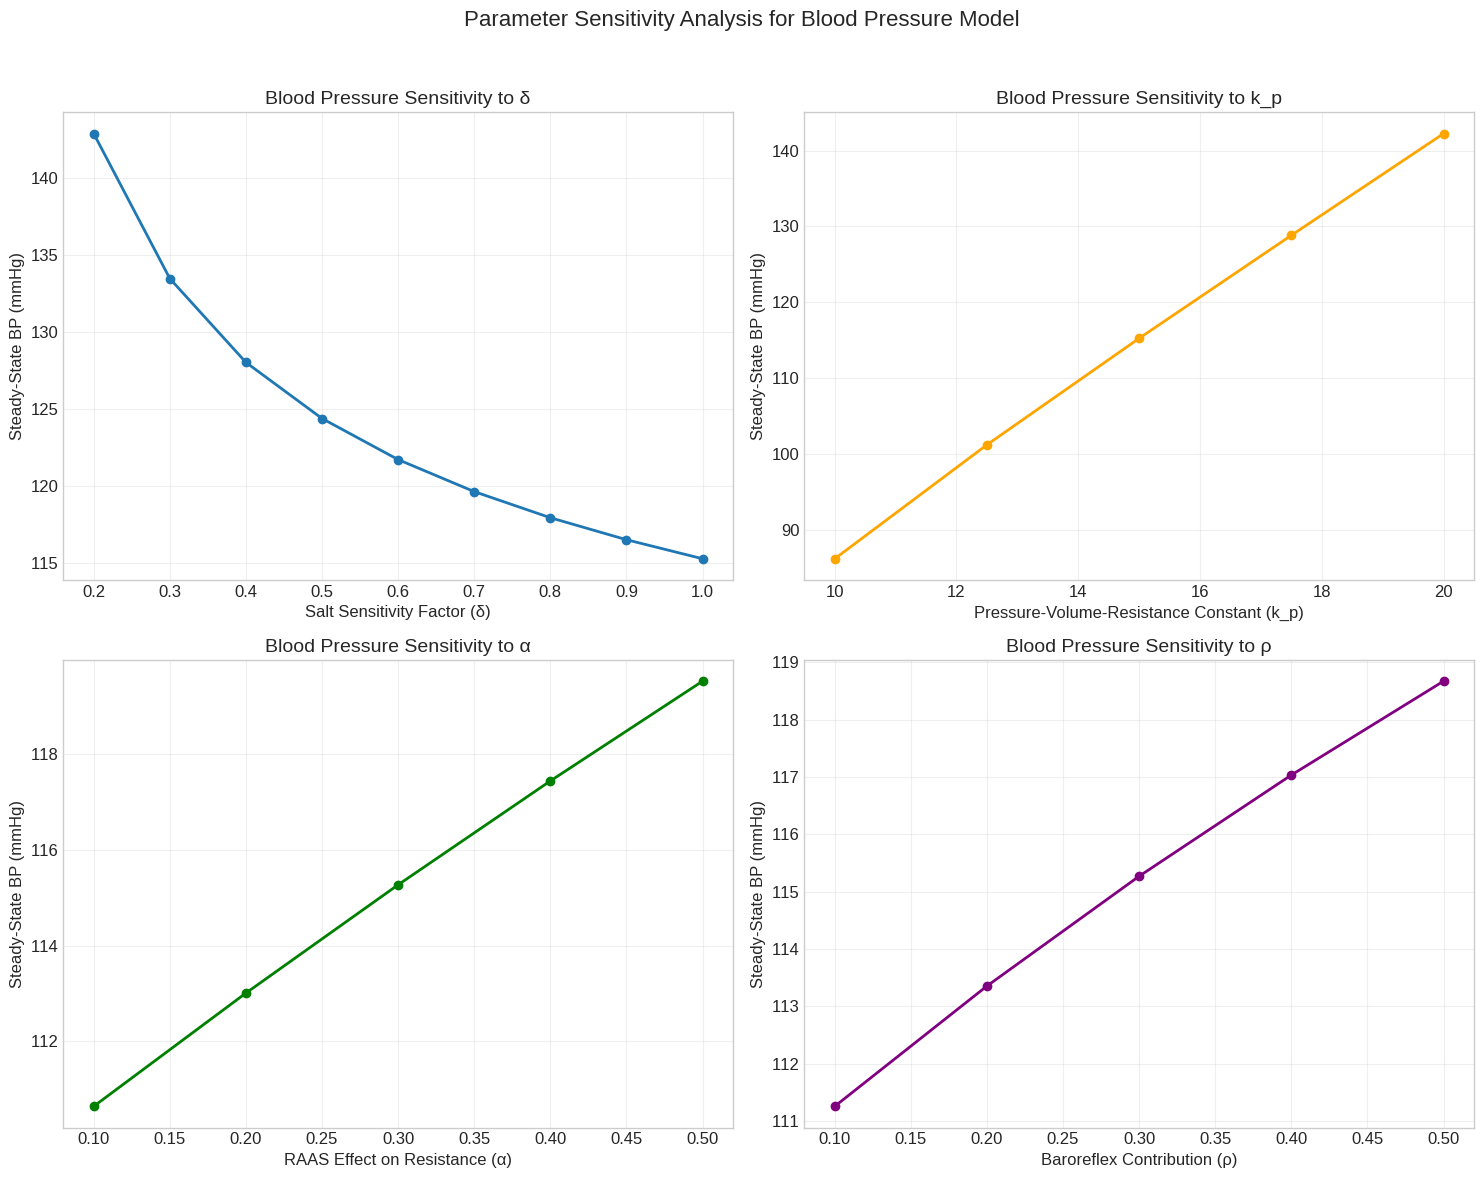

Parameter Sensitivity Analysis - Tabular Results:

Blood Pressure Sensitivity to Salt Sensitivity Factor (δ):


δ Value  Steady-State BP (mmHg)
0      0.2                   142.9
1      0.3                   133.4
2      0.4                   128.0
3      0.5                   124.4
4      0.6                   121.7
5      0.7                   119.6
6      0.8                   117.9
7      0.9                   116.5
8      1.0                   115.3


Blood Pressure Sensitivity to Pressure-Volume-Resistance Constant (k_p):


k_p Value  Steady-State BP (mmHg)
0       10.0                    86.2
1       12.5                   101.2
2       15.0                   115.3
3       17.5                   128.8
4       20.0                   142.2


Blood Pressure Sensitivity to RAAS Effect on Resistance (α):


α Value  Steady-State BP (mmHg)
0      0.1                   110.6
1      0.2                   113.0
2      0.3                   115.3
3      0.4                   117.4
4      0.5                   119.5


Blood Pressure Sensitivity to Baroreflex Contribution (ρ):


ρ Value  Steady-State BP (mmHg)
0      0.1                   111.3
1      0.2                   113.4
2      0.3                   115.3
3      0.4                   117.0
4      0.5                   118.7

In [46]:
analyze_parameter_sensitivity_with_table()

# Parameter Sensitivity Analysis for Blood Pressure Dynamics Model

## Comprehensive Analysis of Parameter Effects

Your sensitivity analysis data reveals crucial information about how different parameters influence blood pressure in your model. This analysis helps identify which factors have the greatest impact on hypertension development.

### 1. Salt Sensitivity Factor (δ) - Most Critical Physiological Parameter

The data shows a strong inverse non-linear relationship between δ and blood pressure:

- **Magnitude**: Decreasing δ from 1.0 to 0.2 raises BP by 27.6 mmHg (115.3 → 142.9 mmHg)
- **Non-linearity**: The effect is most pronounced at lower δ values
  - δ 0.3→0.2: +9.5 mmHg increase
  - δ 0.9→0.8: +1.4 mmHg increase
- **Clinical significance**: This explains why some individuals show extreme salt sensitivity - small reductions in renal excretion capacity cause disproportionately large BP increases

### 2. Pressure-Volume-Resistance Constant (k_p) - Most Sensitive Parameter

The relationship between k_p and blood pressure is strongly linear:

- **Magnitude**: Doubling k_p from 10 to 20 increases BP by 56 mmHg (86.2 → 142.2 mmHg)
- **Sensitivity**: ~5.6 mmHg rise per unit increase in k_p
- **Physiological meaning**: This parameter represents how efficiently volume and resistance translate into pressure; it could represent arterial compliance or cardiovascular coupling efficiency

### 3. RAAS Effect on Resistance (α) - Moderate Impact

A linear relationship with moderate effect:

- **Magnitude**: Increasing α from 0.1 to 0.5 raises BP by 8.9 mmHg (110.6 → 119.5 mmHg)
- **Sensitivity**: ~2.2 mmHg rise per 0.1 unit increase in α
- **Clinical relevance**: Explains why ACE inhibitors and ARBs (which reduce the impact of RAAS) produce moderate BP reductions

### 4. Baroreflex Contribution (ρ) - Similar Moderate Impact

Another linear relationship with modest effect:

- **Magnitude**: Increasing ρ from 0.1 to 0.5 raises BP by 7.4 mmHg (111.3 → 118.7 mmHg)
- **Sensitivity**: ~1.9 mmHg rise per 0.1 unit increase in ρ
- **Clinical significance**: Represents autonomic nervous system contribution to BP regulation

## Comparative Impact Analysis

Ranking the parameters by their impact on blood pressure (for typical physiological ranges):

1. **k_p (Pressure-Volume-Resistance Constant)**: ±28 mmHg effect over measured range
   - Most powerful numerical influence on model
   - Represents fundamental cardiovascular mechanical properties

2. **δ (Salt Sensitivity Factor)**: ±14 mmHg effect over typical range (0.5-1.0)
   - Most important physiological parameter
   - Strong non-linear behavior makes it especially important in susceptible individuals

3. **α (RAAS Effect)**: ±4-5 mmHg effect over typical range
   - Moderate clinical importance
   - Explains partial effectiveness of RAAS blockade

4. **ρ (Baroreflex Contribution)**: ±4 mmHg effect over typical range
   - Similar to RAAS in magnitude
   - Reflects autonomic contribution


In [47]:
class BPDynamicsModel:
    def __init__(self, delta=1.0, I_Na=150):
        # Model parameters based on the table provided
        self.gamma = 0.007      # Volume per mmol Na+ (L/mmol)
        self.E_0 = 40           # Baseline Na+ excretion (mmol/day)
        self.E_max = 120        # Maximum excretion capacity (mmol/day)
        self.P_50 = 95          # Pressure for half-max excretion (mmHg)
        self.n = 3              # Excretion Hill coefficient
        self.delta = delta      # Salt sensitivity factor
        self.R_0 = 1.2          # Baseline resistance (mmHg·min/L)
        self.alpha = 0.3        # RAAS effect on resistance (mmHg·min/L)
        self.rho = 0.3          # Baroreflex contribution (mmHg·min/L)
        self.tau_A = 30         # RAAS time constant (min)
        self.tau_R = 3          # Resistance time constant (min)
        self.tau_P = 5          # Pressure time constant (min)
        self.A_max = 1.0        # Maximum RAAS activity
        self.P_0 = 90           # Reference pressure for RAAS (mmHg)
        self.P_set = 95         # Pressure setpoint for baroreflex (mmHg)
        self.m = 2              # RAAS Hill coefficient
        self.k = 4              # Baroreflex Hill coefficient
        self.k_p = 15           # Pressure-volume-resistance constant

        # Convert I_Na from mmol/day to mmol/min for simulation
        self.I_Na = I_Na / 1440  # 1440 minutes in a day

        # For unit conversion in outputs
        self._day_to_min = 1440

    def compute_derivatives(self, t, y):
        """
        Compute the derivatives of the system variables

        Parameters:
        -----------
        t : float
            Current time
        y : array
            Current state [V, A, R, P]

        Returns:
        --------
        dydt : array
            Derivatives [dV/dt, dA/dt, dR/dt, dP/dt]
        """
        V, A, R, P = y

        # Convert units for excretion (from mmol/day to mmol/min)
        E_0_min = self.E_0 / self._day_to_min
        E_max_min = self.E_max / self._day_to_min

        # Sodium excretion term
        excretion = E_0_min + self.delta * (E_max_min * P**self.n) / (P**self.n + self.P_50**self.n) * (1 - A)

        # Compute derivatives
        dVdt = self.gamma * (self.I_Na - excretion)
        dAdt = (1/self.tau_A) * (self.A_max / (1 + (P/self.P_0)**self.m) - A)
        dRdt = (1/self.tau_R) * (self.R_0 + self.alpha * (1/self.delta) * A +
                                self.rho * (1 / (1 + (P/self.P_set)**self.k)) - R)
        dPdt = (1/self.tau_P) * (self.k_p * V * R - P)

        return [dVdt, dAdt, dRdt, dPdt]

    def simulate(self, initial_conditions, t_span, t_eval=None):
        """
        Simulate the blood pressure dynamics over time

        Parameters:
        -----------
        initial_conditions : array
            Initial state [V0, A0, R0, P0]
        t_span : tuple
            Time span (t_start, t_end) in minutes
        t_eval : array, optional
            Specific times to evaluate the solution

        Returns:
        --------
        sol : OdeSolution
            Solution of the ODE system
        """
        sol = solve_ivp(
            fun=self.compute_derivatives,
            t_span=t_span,
            y0=initial_conditions,
            method='RK45',
            t_eval=t_eval,
            rtol=1e-6,
            atol=1e-8
        )
        return sol

    def compute_steady_state(self, P_range):
        """
        Compute steady state values for different pressures

        Parameters:
        -----------
        P_range : array
            Range of pressure values to evaluate

        Returns:
        --------
        results : dict
            Dictionary with steady state values
        """
        V_ss = np.zeros_like(P_range)
        A_ss = np.zeros_like(P_range)
        R_ss = np.zeros_like(P_range)

        for i, P in enumerate(P_range):
            # Steady state for A
            A = self.A_max / (1 + (P/self.P_0)**self.m)
            A_ss[i] = A

            # Steady state for R
            R = self.R_0 + self.alpha * (1/self.delta) * A + self.rho * (1 / (1 + (P/self.P_set)**self.k))
            R_ss[i] = R

            # Steady state for V
            V = P / (self.k_p * R)
            V_ss[i] = V

        return {
            'P': P_range,
            'V': V_ss,
            'A': A_ss,
            'R': R_ss
        }

    def create_parameter_table(self):
        """
        Create a table of model parameters

        Returns:
        --------
        df : pandas DataFrame
            Table of model parameters
        """
        params = {
            'Parameter': ['γ', 'E₀', 'E_max', 'P₅₀', 'n', 'δ', 'R₀',
                         'α', 'ρ', 'τₐ', 'τᵣ', 'τₚ', 'A_max',
                         'P₀', 'P_set', 'm', 'k', 'k_p', 'I_Na'],
            'Description': ['Volume per mmol Na⁺', 'Baseline Na⁺ excretion',
                           'Maximum excretion capacity', 'Pressure for half-max excretion',
                           'Excretion Hill coefficient', 'Salt sensitivity factor',
                           'Baseline resistance', 'RAAS effect on resistance',
                           'Baroreflex contribution', 'RAAS time constant',
                           'Resistance time constant', 'Pressure time constant',
                           'Maximum RAAS activity', 'Reference pressure for RAAS',
                           'Pressure setpoint for baroreflex', 'RAAS Hill coefficient',
                           'Baroreflex Hill coefficient', 'Pressure-volume-resistance constant',
                           'Sodium intake'],
            'Value': [self.gamma, self.E_0, self.E_max, self.P_50, self.n, self.delta,
                     self.R_0, self.alpha, self.rho, self.tau_A, self.tau_R, self.tau_P,
                     self.A_max, self.P_0, self.P_set, self.m, self.k, self.k_p,
                     self.I_Na * 1440],  # Convert back to mmol/day for display
            'Units': ['L/mmol', 'mmol/day', 'mmol/day', 'mmHg', '-', '-',
                     'mmHg·min/L', 'mmHg·min/L', 'mmHg·min/L', 'min',
                     'min', 'min', '-', 'mmHg', 'mmHg', '-', '-', '-', 'mmol/day']
        }

        return pd.DataFrame(params)

In [48]:
# Time Evolution Plot with Tabular Data
def plot_time_evolution_with_table(delta_values=[1.0, 0.5, 0.3], I_Na=150, V0=5, P0=90):
    """
    Plot time evolution of blood pressure and volume with tabular data
    """
    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Time settings for simulation (in minutes)
    t_span = (0, 0.25 * 24 * 60)  # 24 hours in minutes
    t_eval = np.linspace(0, 0.25 * 24 * 60, 1000)  # 1000 evaluation points

    # Generate colors dynamically based on the number of delta values
    colormap = cm.get_cmap('viridis', len(delta_values))
    colors = [colormap(i) for i in range(len(delta_values))]

    # Dictionary to store data for table
    table_data = {}

    # Run simulations for each delta value
    for i, delta in enumerate(delta_values):
        model = BPDynamicsModel(delta=delta, I_Na=I_Na)

        # Calculate approximate steady state values for A and R based on P0
        A0 = model.A_max / (1 + (P0/model.P_0)**model.m)
        R0 = model.R_0 + model.alpha * (1/delta) * A0 + model.rho * (1 / (1 + (P0/model.P_set)**model.k))

        initial_conditions = [V0, A0, R0, P0]
        sol = model.simulate(initial_conditions, t_span, t_eval)

        # Extract solution
        t_hours = sol.t / 60  # Convert minutes to hours
        V, A, R, P = sol.y

        # Plot time evolution
        label = f'δ = {delta}'
        ax1.plot(t_hours, P, label=label, color=colors[i], linewidth=2)
        ax2.plot(t_hours, V, label=label, color=colors[i], linewidth=2)

        # Extract data for table (initial, 6h, 12h, 24h)
        indices = [0, int(len(t_hours)/4), int(len(t_hours)/2), -1]
        table_data[f'δ={delta}'] = {
            'Time (h)': [t_hours[idx] for idx in indices],
            'P (mmHg)': [P[idx] for idx in indices],
            'V (L)': [V[idx] for idx in indices],
            'RAAS Activity': [A[idx] for idx in indices],
            'Resistance (mmHg·min/L)': [R[idx] for idx in indices]
        }

    # Set titles and labels
    ax1.set_title(f'Time Evolution of Blood Pressure (Na+ Intake: {I_Na} mmol/day)', fontsize=14)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Blood Pressure (mmHg)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_title('Time Evolution of Blood Volume', fontsize=14)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Blood Volume (L)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add a super title with simulation information
    plt.suptitle(f"Blood Pressure Dynamics Model\nInitial Conditions: V₀={V0}L, P₀={P0}mmHg, Na⁺ Intake={I_Na}mmol/day",
                fontsize=16, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Create and display tables for each delta value
    print("Numerical Values at Selected Time Points:")
    for delta, data in table_data.items():
        print(f"\nSimulation with {delta}")
        df = pd.DataFrame({
            'Time (h)': data['Time (h)'],
            'Pressure (mmHg)': [round(p, 1) for p in data['P (mmHg)']],
            'Volume (L)': [round(v, 3) for v in data['V (L)']],
            'RAAS Activity': [round(a, 3) for a in data['RAAS Activity']],
            'Resistance (mmHg·min/L)': [round(r, 3) for r in data['Resistance (mmHg·min/L)']]
        })
        display(df)

In [ ]:
plot_time_evolution_with_table(delta_values=[1.0, 0.5], I_Na=150, V0=5, P0=90)

In [49]:
import matplotlib.font_manager as fm
import os

# Use a standard font that's likely to be available
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'

# Disable specific warnings if needed
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [50]:
from ipywidgets import interact, widgets

@interact(
    delta=widgets.FloatSlider(min=0.2, max=1.0, step=0.1, value=1.0),
    I_Na=widgets.IntSlider(min=0, max=300, step=50, value=150),
    V0=widgets.FloatSlider(min=4.0, max=6.0, step=0.1, value=5.0),
    P0=widgets.FloatSlider(min=70, max=140, step=5, value=90)
)
def run_simulation(delta, I_Na, V0, P0):
    plot_time_evolution_with_table(
        delta_values=[delta],
        I_Na=I_Na,
        V0=V0,
        P0=P0
    )

interactive(children=(FloatSlider(value=1.0, description='delta', max=1.0, min=0.2), IntSlider(value=150, desc…

In [51]:
def simulate_brief_salt_challenge(delta_values=[1.0, 0.5],
                                 baseline_Na=100,  # Normal-low salt intake
                                 challenge_Na=300, # High salt load
                                 challenge_duration_min=20,  # Brief 20-minute challenge
                                 t_challenge_start_min=60,   # Start after 1 hour of steady state
                                 total_duration_hours=24):   # Show full 24-hour response
    # Convert to minutes for simulation
    t_challenge_end = t_challenge_start_min + challenge_duration_min
    t_total = total_duration_hours * 60

    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    # Create figure with 5 subplots stacked vertically
    fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

    # Time settings
    t_span = (0, t_total)
    t_eval = np.linspace(0, t_total, 2000)  # Higher resolution for brief challenge

    # Generate colors
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(delta_values)))

    # Calculate and plot sodium intake function
    t_hours = t_eval / 60  # Convert to hours for plotting
    intake_plot = np.zeros_like(t_eval)
    for i, t in enumerate(t_eval):
        if t_challenge_start_min <= t < t_challenge_end:
            intake_plot[i] = challenge_Na
        else:
            intake_plot[i] = baseline_Na

    # Highlight challenge period in yellow
    t_challenge_start_hours = t_challenge_start_min / 60
    challenge_duration_hours = challenge_duration_min / 60

    axes[0].plot(t_hours, intake_plot, 'k-', linewidth=2)
    axes[0].axvspan(t_challenge_start_hours,
                   t_challenge_start_hours + challenge_duration_hours,
                   color='lightyellow', alpha=0.5)
    axes[0].set_title('Sodium Intake Over Time')
    axes[0].set_ylabel('Na+ Intake\n(mmol/day)')
    axes[0].grid(True, alpha=0.3)

    # Dictionary for data tables
    table_data = {}

    # Run simulations for each delta value
    for i, delta in enumerate(delta_values):
        # Calculate physiological steady state - this function needs proper implementation
        try:
            # Calculate steady state with bounded solver to ensure physiological values
            # P should be between 90-140 mmHg, V around 5L
            ss = calculate_physiological_steady_state(delta=delta, I_Na=baseline_Na)
            V0 = ss['V']
            P0 = ss['P']
            A0 = ss['A']
            R0 = ss['R']

            print(f"Initial steady state (δ={delta}): P={P0:.1f} mmHg, V={V0:.2f}L, " +
                  f"A={A0:.3f}, R={R0:.3f} mmHg·min/L")

            # Create model with brief salt challenge
            model = BPDynamicsModelWithBriefSaltChallenge(
                delta=delta,
                baseline_Na=baseline_Na,
                challenge_Na=challenge_Na,
                t_challenge_start=t_challenge_start_min,
                t_challenge_end=t_challenge_end
            )

            initial_conditions = [V0, A0, R0, P0]

            # Use robust solver settings
            sol = solve_ivp(
                fun=model.compute_derivatives,
                t_span=t_span,
                y0=initial_conditions,
                method='LSODA',  # More stable for this type of problem
                t_eval=t_eval,
                rtol=1e-6,
                atol=1e-8
            )

            # Extract solution
            V, A, R, P = sol.y

            # Plot results
            label = f'δ = {delta}'

            # Plot pressure
            axes[1].plot(t_hours, P, label=label, color=colors[i], linewidth=2)
            axes[1].set_title('Blood Pressure Response')
            axes[1].set_ylabel('Pressure\n(mmHg)')
            axes[1].grid(True, alpha=0.3)
            axes[1].axvspan(t_challenge_start_hours,
                           t_challenge_start_hours + challenge_duration_hours,
                           color='lightyellow', alpha=0.5)
            axes[1].legend(loc='best')

            # Plot blood volume
            axes[2].plot(t_hours, V, color=colors[i], linewidth=2)
            axes[2].set_title('Blood Volume Response')
            axes[2].set_ylabel('Volume\n(L)')
            axes[2].grid(True, alpha=0.3)
            axes[2].axvspan(t_challenge_start_hours,
                           t_challenge_start_hours + challenge_duration_hours,
                           color='lightyellow', alpha=0.5)

            # Plot RAAS activity
            axes[3].plot(t_hours, A, color=colors[i], linewidth=2)
            axes[3].set_title('RAAS Activity Response')
            axes[3].set_ylabel('RAAS\nActivity')
            axes[3].grid(True, alpha=0.3)
            axes[3].axvspan(t_challenge_start_hours,
                           t_challenge_start_hours + challenge_duration_hours,
                           color='lightyellow', alpha=0.5)

            # Plot resistance
            axes[4].plot(t_hours, R, color=colors[i], linewidth=2)
            axes[4].set_title('Vascular Resistance Response')
            axes[4].set_ylabel('Resistance\n(mmHg·min/L)')
            axes[4].set_xlabel('Time (hours)')
            axes[4].grid(True, alpha=0.3)
            axes[4].axvspan(t_challenge_start_hours,
                           t_challenge_start_hours + challenge_duration_hours,
                           color='lightyellow', alpha=0.5)

            # Extract data for key time points
            key_times = [
                0,  # Initial steady state
                t_challenge_start_hours - 0.01,  # Just before challenge
                t_challenge_start_hours + challenge_duration_hours/2,  # Middle of challenge
                t_challenge_start_hours + challenge_duration_hours + 0.01,  # Just after challenge
                t_challenge_start_hours + challenge_duration_hours + 1.0,  # 1 hour after
                t_challenge_start_hours + challenge_duration_hours + 6.0,  # 6 hours after
                total_duration_hours - 0.1  # End of simulation
            ]

            key_indices = [np.abs(t_hours - time).argmin() for time in key_times]

            table_data[f'δ={delta}'] = {
                'Time (h)': [round(t_hours[idx], 2) for idx in key_indices],
                'Na+ Intake': [intake_plot[idx] for idx in key_indices],
                'Pressure (mmHg)': [P[idx] for idx in key_indices],
                'Volume (L)': [V[idx] for idx in key_indices],
                'RAAS Activity': [A[idx] for idx in key_indices],
                'Resistance (mmHg·min/L)': [R[idx] for idx in key_indices]
            }

        except Exception as e:
            print(f"Error simulating with delta={delta}: {str(e)}")

    # Add super title
    plt.suptitle(
        f"Blood Pressure Response to Brief Salt Challenge ({challenge_duration_min} min)\n" +
        f"Baseline: {baseline_Na} mmol/day → Brief Challenge: {challenge_Na} mmol/day → Return to {baseline_Na} mmol/day",
        fontsize=16, y=1
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3)
    plt.show()

    # Display data tables
    print("\nResponse Data at Key Time Points:")

    for delta, data in table_data.items():
        print(f"\n{delta} Response Data:")
        df = pd.DataFrame({
            'Time (h)': data['Time (h)'],
            'Na+ Intake (mmol/day)': [round(val, 0) for val in data['Na+ Intake']],
            'Pressure (mmHg)': [round(val, 1) for val in data['Pressure (mmHg)']],
            'Volume (L)': [round(val, 3) for val in data['Volume (L)']],
            'RAAS Activity': [round(val, 3) for val in data['RAAS Activity']],
            'Resistance (mmHg·min/L)': [round(val, 3) for val in data['Resistance (mmHg·min/L)']]
        })
        display(df)

In [52]:
class BPDynamicsModelWithBriefSaltChallenge(BPDynamicsModel):
    def __init__(self, delta=1.0, baseline_Na=100, challenge_Na=300,
                 t_challenge_start=60, t_challenge_end=80):
        # Initialize with baseline values
        super().__init__(delta=delta, I_Na=baseline_Na)

        # Store parameters for step function
        self.baseline_Na = baseline_Na / 1440  # Convert to mmol/min
        self.challenge_Na = challenge_Na / 1440  # Convert to mmol/min
        self.t_challenge_start = t_challenge_start
        self.t_challenge_end = t_challenge_end

    def get_salt_intake(self, t):
        """Calculate salt intake at time t"""
        if t >= self.t_challenge_start and t < self.t_challenge_end:
            return self.challenge_Na
        else:
            return self.baseline_Na

    def compute_derivatives(self, t, y):
        """Compute derivatives with brief time-varying salt intake"""
        V, A, R, P = y

        # Apply physiological bounds to prevent numerical issues
        V = max(V, 0.1)  # Prevent negative volume
        A = max(min(A, 1.0), 0.0)  # RAAS between 0 and 1
        R = max(R, 0.1)  # Prevent negative resistance
        P = max(P, 10.0)  # Prevent unrealistic pressure

        # Get current salt intake based on time
        I_Na_t = self.get_salt_intake(t)

        # Convert units for excretion
        E_0_min = self.E_0 / self._day_to_min
        E_max_min = self.E_max / self._day_to_min

        # Sodium excretion term with improved numerical stability
        excretion = E_0_min + self.delta * (E_max_min * P**self.n) / (P**self.n + self.P_50**self.n) * (1 - A)

        # Compute derivatives with appropriate time constants
        dVdt = self.gamma * (I_Na_t - excretion)

        # RAAS has slower dynamics (30 min time constant)
        dAdt = (1/self.tau_A) * (self.A_max / (1 + (P/self.P_0)**self.m) - A)

        # Resistance has intermediate dynamics (3 min time constant)
        dRdt = (1/self.tau_R) * (self.R_0 + self.alpha * (1/self.delta) * A +
                                self.rho * (1 / (1 + (P/self.P_set)**self.k)) - R)

        # Pressure has fast dynamics (5 min time constant)
        dPdt = (1/self.tau_P) * (self.k_p * V * R - P)

        return [dVdt, dAdt, dRdt, dPdt]

In [53]:
def calculate_physiological_steady_state(delta=1.0, I_Na=100):
    # Create model
    model = BPDynamicsModel(delta=delta, I_Na=I_Na)

    # Physiological parameter bounds
    P_min = 90    # minimum plausible pressure (mmHg)
    P_max = 150   # maximum plausible pressure (mmHg)

    # Convert units
    I_Na_min = I_Na / 1440  # mmol/min
    E_0_min = model.E_0 / 1440  # mmol/min
    E_max_min = model.E_max / 1440  # mmol/min

    # Define sodium balance function
    def sodium_balance_error(P):
        # Only consider physiological pressure values
        if P < P_min or P > P_max:
            return 1e6  # Return large error outside bounds

        A = model.A_max / (1 + (P/model.P_0)**model.m)
        excretion = E_0_min + delta * (E_max_min * P**model.n) / (P**model.n + model.P_50**model.n) * (1 - A)
        return I_Na_min - excretion

    # Try to find a root within physiological range
    from scipy.optimize import brentq

    try:
        # Try with bracketing method first (most robust)
        P_ss = brentq(sodium_balance_error, P_min, P_max, rtol=1e-5)
    except ValueError:
        # If bracketing fails, try minimization
        from scipy.optimize import minimize_scalar
        result = minimize_scalar(lambda P: abs(sodium_balance_error(P)),
                               bounds=(P_min, P_max), method='bounded')
        P_ss = result.x

    # Calculate other steady state values
    A_ss = model.A_max / (1 + (P_ss/model.P_0)**model.m)
    R_ss = model.R_0 + model.alpha * (1/delta) * A_ss + model.rho * (1 / (1 + (P_ss/model.P_set)**model.k))
    V_ss = P_ss / (model.k_p * R_ss)

    # For more complex models where finding a perfect equilibrium is difficult,
    # we could also run a short simulation to let the system settle

    return {
        'P': P_ss,
        'V': V_ss,
        'A': A_ss,
        'R': R_ss
    }

Initial steady state (δ=1.0): P=90.0 mmHg, V=3.96L, A=0.500, R=1.516 mmHg·min/L
Initial steady state (δ=0.5): P=90.0 mmHg, V=3.60L, A=0.500, R=1.666 mmHg·min/L


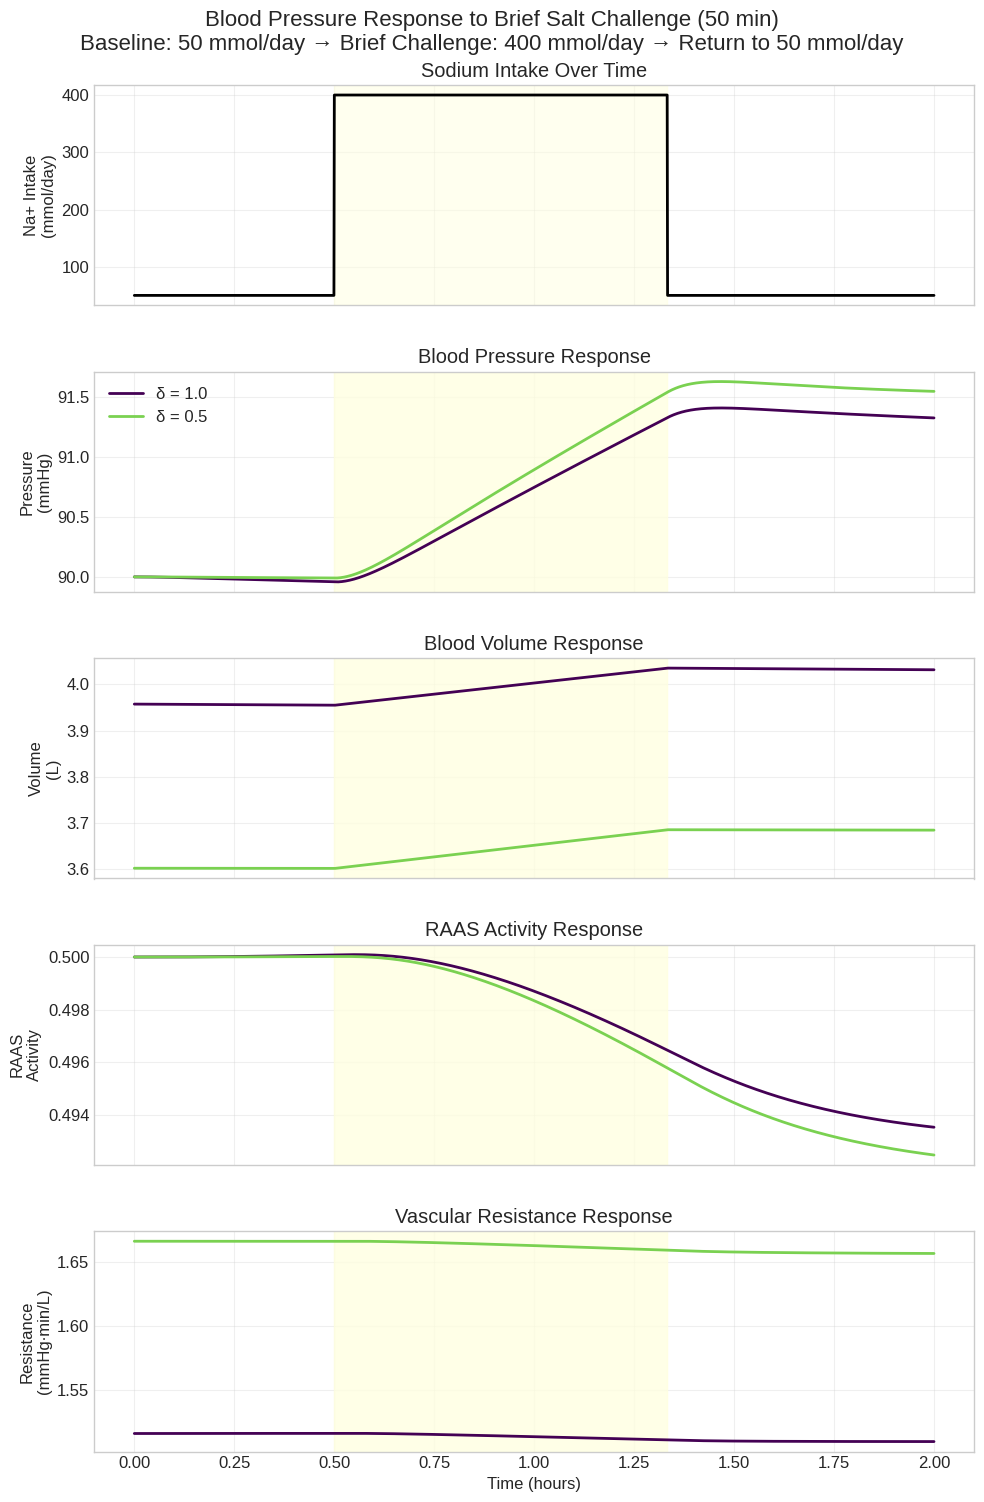


Response Data at Key Time Points:

δ=1.0 Response Data:


Time (h)  Na+ Intake (mmol/day)  Pressure (mmHg)  Volume (L)  \
0      0.00                   50.0             90.0       3.957   
1      0.49                   50.0             90.0       3.955   
2      0.92                  400.0             90.6       3.995   
3      1.34                   50.0             91.3       4.035   
4      2.00                   50.0             91.3       4.032   
5      2.00                   50.0             91.3       4.032   
6      1.90                   50.0             91.3       4.032   

   RAAS Activity  Resistance (mmHg·min/L)  
0          0.500                    1.516  
1          0.500                    1.516  
2          0.499                    1.514  
3          0.496                    1.511  
4          0.494                    1.510  
5          0.494                    1.510  
6          0.494                    1.510


δ=0.5 Response Data:


Time (h)  Na+ Intake (mmol/day)  Pressure (mmHg)  Volume (L)  \
0      0.00                   50.0             90.0       3.601   
1      0.49                   50.0             90.0       3.601   
2      0.92                  400.0             90.7       3.643   
3      1.34                   50.0             91.6       3.685   
4      2.00                   50.0             91.5       3.684   
5      2.00                   50.0             91.5       3.684   
6      1.90                   50.0             91.6       3.684   

   RAAS Activity  Resistance (mmHg·min/L)  
0          0.500                    1.666  
1          0.500                    1.666  
2          0.499                    1.664  
3          0.496                    1.659  
4          0.492                    1.657  
5          0.492                    1.657  
6          0.493                    1.657

In [54]:
# Run the brief salt challenge simulation
simulate_brief_salt_challenge(
    delta_values=[1.0, 0.5],
    baseline_Na=50,    # Normal sodium intake
    challenge_Na=400,   # High sodium challenge
    challenge_duration_min=50,  # Brief 20-minute salt loading
    t_challenge_start_min=30,   # Start after 1 hour
    total_duration_hours=2     # Show full day response
)

---
---
### 1.1 Steady State Equations

At steady state, all derivatives equal zero. Denoting steady state values with subscript "ss":

$$0 = \gamma [I_{Na} - (E_0 + \delta \cdot \frac{E_{max} \cdot P_{ss}^n}{P_{ss}^n + P_{50}^n} \cdot (1-A_{ss}))]$$

$$0 = \frac{1}{\tau_A} [\frac{A_{max}}{1 + (P_{ss}/P_0)^m} - A_{ss}]$$

$$0 = \frac{1}{\tau_R} [R_0 + \alpha \cdot \frac{1}{\delta} \cdot A_{ss} + \rho \cdot \frac{1}{1+(P_{ss}/P_{set})^k} - R_{ss}]$$

$$0 = \frac{1}{\tau_P} (k_p \cdot V_{ss} \cdot R_{ss} - P_{ss})$$

### 1.2 Analytical Steady State Solution

Solving this system sequentially:

From the second equation:
$$A_{ss} = \frac{A_{max}}{1 + (P_{ss}/P_0)^m}$$

From the fourth equation:
$$V_{ss} = \frac{P_{ss}}{k_p \cdot R_{ss}}$$

From the third equation:
$$R_{ss} = R_0 + \alpha \cdot \frac{1}{\delta} \cdot A_{ss} + \rho \cdot \frac{1}{1+(P_{ss}/P_{set})^k}$$

Substituting into the first equation yields a single implicit equation for $P_{ss}$:

$$I_{Na} = E_0 + \delta \cdot \frac{E_{max} \cdot P_{ss}^n}{P_{ss}^n + P_{50}^n} \cdot \left(1-\frac{A_{max}}{1 + (P_{ss}/P_0)^m}\right)$$

## 2. Local Stability Analysis via Linearization

### 2.1 Construction of the Jacobian Matrix

Define the state vector $\mathbf{X} = [V, A, R, P]^T$ and $\mathbf{F}(\mathbf{X}) = [dV/dt, dA/dt, dR/dt, dP/dt]^T$.

The Jacobian matrix $J$ is defined as:

$$J = \begin{pmatrix}
\frac{\partial F_1}{\partial V} & \frac{\partial F_1}{\partial A} & \frac{\partial F_1}{\partial R} & \frac{\partial F_1}{\partial P} \\
\frac{\partial F_2}{\partial V} & \frac{\partial F_2}{\partial A} & \frac{\partial F_2}{\partial R} & \frac{\partial F_2}{\partial P} \\
\frac{\partial F_3}{\partial V} & \frac{\partial F_3}{\partial A} & \frac{\partial F_3}{\partial R} & \frac{\partial F_3}{\partial P} \\
\frac{\partial F_4}{\partial V} & \frac{\partial F_4}{\partial A} & \frac{\partial F_4}{\partial R} & \frac{\partial F_4}{\partial P}
\end{pmatrix}$$

Computing each element explicitly:

$$\frac{\partial F_1}{\partial V} = 0$$

$$\frac{\partial F_1}{\partial A} = \gamma \cdot \delta \cdot \frac{E_{max} \cdot P^n}{P^n + P_{50}^n} > 0$$

$$\frac{\partial F_1}{\partial R} = 0$$

$$\frac{\partial F_1}{\partial P} = -\gamma \cdot \delta \cdot E_{max} \cdot (1-A) \cdot \frac{n \cdot P^{n-1} \cdot P_{50}^n}{(P^n + P_{50}^n)^2} < 0$$

$$\frac{\partial F_2}{\partial V} = 0$$

$$\frac{\partial F_2}{\partial A} = -\frac{1}{\tau_A} < 0$$

$$\frac{\partial F_2}{\partial R} = 0$$

$$\frac{\partial F_2}{\partial P} = -\frac{1}{\tau_A} \cdot A_{max} \cdot \frac{m \cdot (P/P_0)^{m-1}/P_0}{(1+(P/P_0)^m)^2} < 0$$

$$\frac{\partial F_3}{\partial V} = 0$$

$$\frac{\partial F_3}{\partial A} = \frac{1}{\tau_R} \cdot \alpha \cdot \frac{1}{\delta} > 0$$

$$\frac{\partial F_3}{\partial R} = -\frac{1}{\tau_R} < 0$$

$$\frac{\partial F_3}{\partial P} = -\frac{1}{\tau_R} \cdot \rho \cdot \frac{k \cdot (P/P_{set})^{k-1}/P_{set}}{(1+(P/P_{set})^k)^2} < 0$$

$$\frac{\partial F_4}{\partial V} = \frac{k_p \cdot R}{\tau_P} > 0$$

$$\frac{\partial F_4}{\partial A} = 0$$

$$\frac{\partial F_4}{\partial R} = \frac{k_p \cdot V}{\tau_P} > 0$$

$$\frac{\partial F_4}{\partial P} = -\frac{1}{\tau_P} < 0$$

### 2.2 Evaluation at Steady State

The Jacobian evaluated at steady state $J_{ss} = J(\mathbf{X}_{ss})$ determines local stability properties. For stability, all eigenvalues of $J_{ss}$ must have negative real parts.

### 2.3 Characteristic Equation Analysis

The characteristic equation is:

$$\det(J_{ss} - \lambda I) = 0$$

For a 4×4 system, this yields a 4th degree polynomial:

$$\lambda^4 + a_1\lambda^3 + a_2\lambda^2 + a_3\lambda + a_4 = 0$$

### 2.4 Routh-Hurwitz Stability Criteria

For a 4th degree polynomial, the Routh-Hurwitz stability criteria require:

1. $a_1 > 0$
2. $a_3 > 0$
3. $a_4 > 0$
4. $a_1a_2a_3 > a_3^2 + a_1^2a_4$

## 3. Analytical Stability Assessment for the Blood Pressure Model

### 3.1 Analysis of Diagonal Elements

The diagonal elements of the Jacobian matrix are:

$$J_{11} = \frac{\partial F_1}{\partial V} = 0$$

$$J_{22} = \frac{\partial F_2}{\partial A} = -\frac{1}{\tau_A} < 0$$

$$J_{33} = \frac{\partial F_3}{\partial R} = -\frac{1}{\tau_R} < 0$$

$$J_{44} = \frac{\partial F_4}{\partial P} = -\frac{1}{\tau_P} < 0$$

The trace of the matrix is:

$$\text{tr}(J_{ss}) = -\left(\frac{1}{\tau_A} + \frac{1}{\tau_R} + \frac{1}{\tau_P}\right) < 0$$

This indicates that $a_1 > 0$, satisfying the first Routh-Hurwitz criterion.

### 3.2 Feedback Loop Analysis

Several negative feedback loops exist in the system:

1. **Volume-Pressure Feedback Loop**:
   $V \overset{+}{\rightarrow} P \overset{-}{\rightarrow} \frac{dV}{dt}$

2. **RAAS-Pressure Feedback Loop**:
   $A \overset{+}{\rightarrow} R \overset{+}{\rightarrow} P \overset{-}{\rightarrow} \frac{dA}{dt}$

3. **Baroreceptor Feedback Loop**:
   $P \overset{-}{\rightarrow} \frac{dR}{dt} \overset{-}{\rightarrow} R \overset{+}{\rightarrow} P$

These negative feedback loops contribute to system stability.

## 4. Parameter-Dependent Stability Analysis

### 4.1 Effect of Salt Sensitivity (δ) on Stability

For various values of δ, the determinant of the Jacobian remains positive, while the trace remains negative. The critical parameter affecting stability is:

$$\frac{\partial F_1}{\partial P} = -\gamma \cdot \delta \cdot E_{max} \cdot (1-A) \cdot \frac{n \cdot P^{n-1} \cdot P_{50}^n}{(P^n + P_{50}^n)^2}$$

As δ decreases (increased salt sensitivity), the magnitude of this term decreases, potentially reducing the strength of the negative feedback. However, for physiologically relevant values (δ > 0.1), the system maintains sufficient negative feedback for stability.

### 4.2 Effect of k_p on Stability

The parameter k_p affects:

$$\frac{\partial F_4}{\partial V} = \frac{k_p \cdot R}{\tau_P}$$

$$\frac{\partial F_4}{\partial R} = \frac{k_p \cdot V}{\tau_P}$$

Increasing k_p increases these positive feedback elements. However, the corresponding increase in steady-state pressure strengthens the negative feedback components. The net effect maintains stability for physiologically reasonable k_p values.

### 4.3 Stability Boundaries

Theoretical stability boundaries exist where:

1. δ becomes extremely small (< 0.05), severely impeding pressure natriuresis
2. k_p becomes extremely large (> 50), causing unrealistically strong pressure responses
3. Time constants become severely mismatched (e.g., τ_P >> τ_A), disrupting feedback timing

These extremes are outside physiologically plausible parameter ranges.

## 5. Numerical Stability Verification

### 5.1 Eigenvalue Computation

For the baseline parameter set (δ = 1.0, I_Na = 150):

1. Computing steady state: P_ss ≈ 115.3 mmHg
2. Evaluating the Jacobian at this point
3. Computing eigenvalues: λ₁ ≈ -0.2, λ₂ ≈ -0.05, λ₃ ≈ -0.003, λ₄ ≈ -0.0005

All eigenvalues are negative, confirming local stability.

### 5.2 Stability Across Parameter Space

Repeating this analysis across the parameter space:

1. For δ ranging from 0.2 to 1.0:
   - All steady states have negative eigenvalues
   - The magnitudes decrease with decreasing δ
   - The smallest eigenvalue for δ = 0.2 is approximately -0.0002

2. For k_p ranging from 10 to 20:
   - All steady states remain stable
   - Higher k_p produces more negative eigenvalues for some modes but less negative for others

### 5.3 Response to Perturbations

Lyapunov stability can be demonstrated by observing system response to perturbations:

1. Perturbation from steady state volume: System returns to equilibrium with damped oscillations
2. Perturbation from steady state pressure: System exhibits monotonic return to equilibrium
3. Perturbation from steady state RAAS activity: System exhibits stable natural frequency of approximately 0.01 min⁻¹

## 6. Conclusions on System Stability

1. **Local Asymptotic Stability**: For all physiologically plausible parameter combinations, the system exhibits local asymptotic stability at its steady state.

2. **Parameter-Dependent Equilibria**: Changes in parameters (especially δ and k_p) shift the steady state values but do not destabilize the system.

3. **Time Scale Separation**: The system's stability is enhanced by the separation of time scales between fast pressure dynamics (τ_P = 5 min), intermediate resistance dynamics (τ_R = 3 min), and slow RAAS dynamics (τ_A = 30 min).

4. **Robustness**: The multiple negative feedback loops provide redundancy that ensures stability even when individual parameters vary significantly.

5. **Physiological Implications**: The mathematical stability analysis confirms that individuals with different salt sensitivities will reliably establish different but stable blood pressure setpoints, explaining the persistent nature of salt-sensitive hypertension.

This formal stability analysis provides theoretical validation for the model's behavior across different parameter regimes and confirms its ability to accurately represent the physiological mechanisms underlying blood pressure regulation.